In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

# Circuito

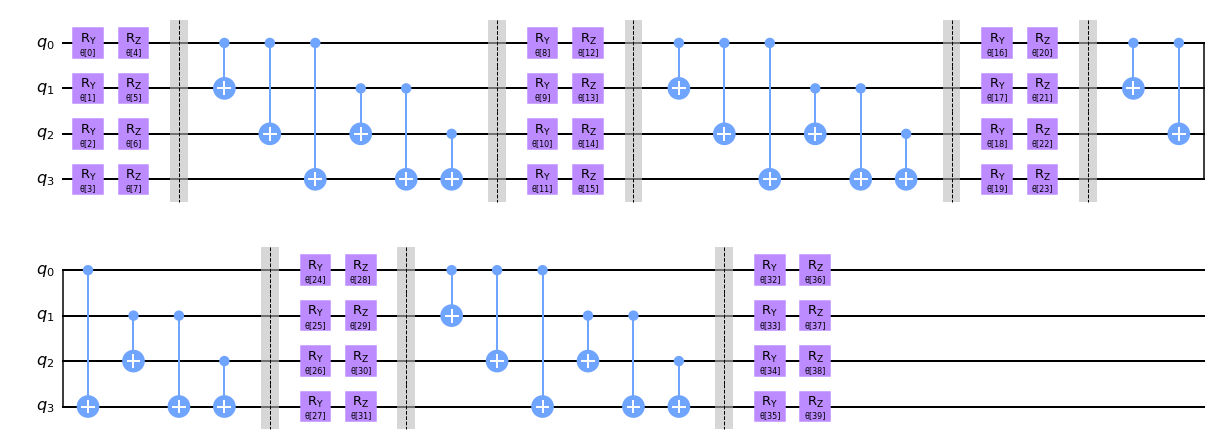

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()
ansatz.decompose().draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [8]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [9]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        #print(exp_val)
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)*(y-y_hat)

In [10]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Valor expectávlel -0.62109375, Label -1 
Valor expectávlel -0.44140625, Label -1 
Valor expectávlel -0.57421875, Label -1 
Valor expectávlel -0.5625, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.564453125, Label -1 
Valor expectávlel -0.4765625, Label -1 
Valor expectávlel -0.515625, Label -1 
Valor expectávlel -0.5234375, Label -1 
Valor expectávlel -0.603515625, Label -1 
Valor expectávlel -0.552734375, Label -1 
Valor expectávlel -0.576171875, Label -1 
Valor expectávlel -0.509765625, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.525390625, Label -1 
Valor expectávlel -0.537109375, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.537109375, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.564453125, Label -1 
Valor expectávlel -0.505859375, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.58203125, Label -1 
Valor expectávlel -0.392578125, Label -1 
Valor expectáv

Valor expectávlel -0.556640625, Label -1 
Valor expectávlel -0.466796875, Label -1 
Valor expectávlel -0.5703125, Label -1 
Valor expectávlel -0.5859375, Label -1 
Valor expectávlel -0.533203125, Label -1 
Valor expectávlel -0.560546875, Label -1 
Valor expectávlel -0.57421875, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.56640625, Label -1 
Valor expectávlel -0.546875, Label -1 
Valor expectávlel -0.537109375, Label -1 
Valor expectávlel -0.5390625, Label -1 
Valor expectávlel -0.53515625, Label -1 
Valor expectávlel -0.576171875, Label -1 
Valor expectávlel -0.5625, Label -1 
Valor expectávlel -0.537109375, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.611328125, Label -1 
Valor expectávlel -0.439453125, Label -1 
Valor expectávlel -0.544921875, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.537109375, Label -1 
Valor expectávlel -0.515625, Label -1 
Valor expectávle

Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.326171875, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.345703125, Label -1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel -0.349609375, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávl

Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor expectávlel -0.287109375, Label -1 
Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel 0.041015625, Label 1 
Valor expectávlel -0.0

Valor expectávlel -0.4765625, Label -1 
Valor expectávlel -0.37109375, Label -1 
Valor expectávlel -0.451171875, Label -1 
Valor expectávlel -0.435546875, Label -1 
Valor expectávlel -0.44921875, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.447265625, Label -1 
Valor expectávlel -0.462890625, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.44921875, Label -1 
Valor expectávlel -0.470703125, Label -1 
Valor expectávlel -0.484375, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.4609375, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.447265625, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.427734375, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.455078125, Label -1 
Valor expectávlel -0.38671875, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.470703125, Label -1 
Valor expectávlel -0.41796875, Label -1 
Valor exp

Valor expectávlel -0.548828125, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.64453125, Label -1 
Valor expectávlel -0.5859375, Label -1 
Valor expectávlel -0.51953125, Label -1 
Valor expectávlel -0.59765625, Label -1 
Valor expectávlel -0.484375, Label -1 
Valor expectávlel -0.52734375, Label -1 
Valor expectávlel -0.490234375, Label -1 
Valor expectávlel -0.64453125, Label -1 
Valor expectávlel -0.525390625, Label -1 
Valor expectávlel -0.62109375, Label -1 
Valor expectávlel -0.4921875, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.525390625, Label -1 
Valor expectávlel -0.53515625, Label -1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel -0.560546875, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.62890625, Label -1 
Valor expectávlel -0.455078125, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.607421875, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0

Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.353515625, Label -1 
Valor expectávlel -0.3046875, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.349609375, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.345703125, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.232421875, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.283203125, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.361328125, Label -1 
Valor expectávlel -0.38671875, Label -1 
Valor exp

Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.2734375, Label -1 
Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.283203125, Label -1 
Valor expectávlel -0.279296875, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -

Valor expectávlel -0.376953125, Label -1 
Valor expectávlel -0.365234375, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.388671875, Label -1 
Valor expectávlel -0.421875, Label -1 
Valor expectávlel -0.359375, Label -1 
Valor expectávlel -0.373046875, Label -1 
Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.400390625, Label -1 
Valor expectávlel -0.40625, Label -1 
Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.416015625, Label -1 
Valor expectávlel -0.416015625, Label -1 
Valor expectávlel -0.447265625, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.41015625, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.41796875, Label -1 
Valor expectávlel -0.447265625, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expect

Valor expectávlel -0.701171875, Label -1 
Valor expectávlel -0.5546875, Label -1 
Valor expectávlel -0.771484375, Label -1 
Valor expectávlel -0.724609375, Label -1 
Valor expectávlel -0.71875, Label -1 
Valor expectávlel -0.70703125, Label -1 
Valor expectávlel -0.6171875, Label -1 
Valor expectávlel -0.69140625, Label -1 
Valor expectávlel -0.703125, Label -1 
Valor expectávlel -0.71484375, Label -1 
Valor expectávlel -0.689453125, Label -1 
Valor expectávlel -0.701171875, Label -1 
Valor expectávlel -0.642578125, Label -1 
Valor expectávlel -0.74609375, Label -1 
Valor expectávlel -0.70703125, Label -1 
Valor expectávlel -0.736328125, Label -1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.75390625, Label -1 
Valor expectávlel -0.53125, Label -1 
Valor expectávlel -0.75390625, Label -1 
Valor expectávlel -0.650390625, Label -1 
Valor expectávlel -0.484375, Label -1 
Valor expectávlel -0.732421875, Label -1 
Valor expectávlel -0.556640625, Label -1 
Valor expectávlel

Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.296875, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.283203125, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expectávlel -0.3359375, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.3203125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor ex

Valor expectávlel -0.466796875, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.484375, Label -1 
Valor expectávlel -0.494140625, Label -1 
Valor expectávlel -0.517578125, Label -1 
Valor expectávlel -0.51953125, Label -1 
Valor expectávlel -0.51953125, Label -1 
Valor expectávlel -0.458984375, Label -1 
Valor expectávlel -0.453125, Label -1 
Valor expectávlel -0.541015625, Label -1 
Valor expectávlel -0.439453125, Label -1 
Valor expectávlel -0.50390625, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.50390625, Label -1 
Valor expectávlel -0.517578125, Label -1 
Valor expectávlel -0.453125, Label -1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel -0.48828125, Label -1 
Valor expectávlel -0.376953125, Label -1 
Valor expectávlel -0.533203125, Label -1 
Valor expectávlel -0.5078125, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.568359375, Label -1 
Valor expectávlel -0.4765625, Label -1 
Valor expectá

Valor expectávlel -0.64453125, Label -1 
Valor expectávlel -0.69140625, Label -1 
Valor expectávlel -0.625, Label -1 
Valor expectávlel -0.677734375, Label -1 
Valor expectávlel -0.677734375, Label -1 
Valor expectávlel -0.6796875, Label -1 
Valor expectávlel -0.654296875, Label -1 
Valor expectávlel -0.69921875, Label -1 
Valor expectávlel -0.681640625, Label -1 
Valor expectávlel -0.640625, Label -1 
Valor expectávlel -0.68359375, Label -1 
Valor expectávlel -0.65625, Label -1 
Valor expectávlel -0.70703125, Label -1 
Valor expectávlel -0.712890625, Label -1 
Valor expectávlel -0.646484375, Label -1 
Valor expectávlel -0.66796875, Label -1 
Valor expectávlel -0.396484375, Label -1 
Valor expectávlel -0.650390625, Label -1 
Valor expectávlel -0.666015625, Label -1 
Valor expectávlel -0.630859375, Label -1 
Valor expectávlel -0.669921875, Label -1 
Valor expectávlel -0.6796875, Label -1 
Valor expectávlel -0.658203125, Label -1 
Valor expectávlel -0.720703125, Label -1 
Valor expectávl

Valor expectávlel -0.638671875, Label -1 
Valor expectávlel -0.51171875, Label -1 
Valor expectávlel -0.576171875, Label -1 
Valor expectávlel -0.626953125, Label -1 
Valor expectávlel -0.626953125, Label -1 
Valor expectávlel -0.58984375, Label -1 
Valor expectávlel -0.55078125, Label -1 
Valor expectávlel -0.595703125, Label -1 
Valor expectávlel -0.529296875, Label -1 
Valor expectávlel -0.59375, Label -1 
Valor expectávlel -0.58984375, Label -1 
Valor expectávlel -0.544921875, Label -1 
Valor expectávlel -0.556640625, Label -1 
Valor expectávlel -0.623046875, Label -1 
Valor expectávlel -0.546875, Label -1 
Valor expectávlel -0.58984375, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.572265625, Label -1 
Valor expectávlel -0.44140625, Label -1 
Valor expectávlel -0.583984375, Label -1 
Valor expectávlel -0.515625, Label -1 
Valor expectávlel -0.4921875, Label -1 
Valor expectávlel -0.62890625, Label -1 
Valor expectávlel -0.462890625, Label -1 
Valor expec

Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.14453125, Label -1 
Valor expectávlel -0.15234375, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.14453125, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.126953125, Label -1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor 

Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.4609375, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.380859375, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.470703125, Label 1 
Valor expectávlel 0.4609375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.

Valor expectávlel -0.037109375, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel -0.037109375, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.017578125, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectáv

Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.357421875, Label -1 
Valor expectávlel -0.359375, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.314453125, Label -1 
Valor expectávlel -0.375, Label -1 
Valor expectávlel -0.296875, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.337890625, Label -1 
Valor expectávlel -0.337890625, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel -0.388671875, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.337890625, Label -1 
Valor expectávlel -0.232421875, Label -1 
Valor expectávlel

Valor expectávlel -0.345703125, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.265625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.35546875, Label -1 
Valor expectávlel -0.3125, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel -0.396484375, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.423828125, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel 

Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.26171875, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.220703125, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.2

Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.03125, Label 1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.078125, L

Valor expectávlel -0.140625, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.12890625, Label -1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.216796875, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.001953

Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.09765625, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.123046875, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.1640625, L

Valor expectávlel -0.1015625, Label -1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.107421875, Label -1 
Valor expectávlel -0.111328125, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.126953125, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.15

Valor expectávlel -0.0234375, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel 0.01953125, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.291015625, Label

Valor expectávlel -0.3515625, Label -1 
Valor expectávlel -0.220703125, Label -1 
Valor expectávlel -0.205078125, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.365234375, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expectávlel -0.279296875, Label -1 
Valor expectávlel -0.3125, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.37109375, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.314453125, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.345703125, Label -1 
Valor expectávle

Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel -0.017578125, Label -1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.03515625, Lab

Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.115

Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.12890625, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel -0.15234375, Label -1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávl

Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.255859375, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.248046875, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.19

Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.248046875, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.1855468

Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.041015625, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.

Valor expectávlel 0.03125, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel -0.009765625, Label -1 
Valor expectávlel 0.0234375, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.08203125,

Valor expectávlel -0.40625, Label -1 
Valor expectávlel -0.30078125, Label -1 
Valor expectávlel -0.455078125, Label -1 
Valor expectávlel -0.453125, Label -1 
Valor expectávlel -0.380859375, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.3671875, Label -1 
Valor expectávlel -0.431640625, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.357421875, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.41015625, Label -1 
Valor expectávlel -0.375, Label -1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel -0.4453125, Label -1 
Valor expectávlel -0.197265625, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.359375, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel -0.3203125, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.2773437

Valor expectávlel -0.625, Label -1 
Valor expectávlel -0.56640625, Label -1 
Valor expectávlel -0.71875, Label -1 
Valor expectávlel -0.65625, Label -1 
Valor expectávlel -0.65625, Label -1 
Valor expectávlel -0.6171875, Label -1 
Valor expectávlel -0.572265625, Label -1 
Valor expectávlel -0.626953125, Label -1 
Valor expectávlel -0.607421875, Label -1 
Valor expectávlel -0.658203125, Label -1 
Valor expectávlel -0.6328125, Label -1 
Valor expectávlel -0.68359375, Label -1 
Valor expectávlel -0.578125, Label -1 
Valor expectávlel -0.6640625, Label -1 
Valor expectávlel -0.576171875, Label -1 
Valor expectávlel -0.646484375, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.6484375, Label -1 
Valor expectávlel -0.51953125, Label -1 
Valor expectávlel -0.669921875, Label -1 
Valor expectávlel -0.544921875, Label -1 
Valor expectávlel -0.53515625, Label -1 
Valor expectávlel -0.68359375, Label -1 
Valor expectávlel -0.388671875, Label -1 
Valor expectávlel -0.3964843

Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.3046875, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.16796875, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.23046875, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.3125, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.2

Valor expectávlel -0.41796875, Label -1 
Valor expectávlel -0.525390625, Label -1 
Valor expectávlel -0.423828125, Label -1 
Valor expectávlel -0.4375, Label -1 
Valor expectávlel -0.439453125, Label -1 
Valor expectávlel -0.48046875, Label -1 
Valor expectávlel -0.423828125, Label -1 
Valor expectávlel -0.490234375, Label -1 
Valor expectávlel -0.4765625, Label -1 
Valor expectávlel -0.375, Label -1 
Valor expectávlel -0.416015625, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.4375, Label -1 
Valor expectávlel -0.455078125, Label -1 
Valor expectávlel -0.46875, Label -1 
Valor expectávlel -0.494140625, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.4453125, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.400390625, Label -1 
Valor expectávlel -0.453125, Label -1 
Valor expectávlel -0.4296875, Label -1 
Valor expectávlel -0.365234375, Label -1 
Valor expectávlel -0.400390625, Label -1 
Valor expectávlel -0.3964843

Valor expectávlel -0.490234375, Label -1 
Valor expectávlel -0.44921875, Label -1 
Valor expectávlel -0.490234375, Label -1 
Valor expectávlel -0.515625, Label -1 
Valor expectávlel -0.513671875, Label -1 
Valor expectávlel -0.4765625, Label -1 
Valor expectávlel -0.435546875, Label -1 
Valor expectávlel -0.482421875, Label -1 
Valor expectávlel -0.486328125, Label -1 
Valor expectávlel -0.486328125, Label -1 
Valor expectávlel -0.46875, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.52734375, Label -1 
Valor expectávlel -0.51953125, Label -1 
Valor expectávlel -0.486328125, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.5078125, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.48046875, Label -1 
Valor expectávlel -0.458984375, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expect

Valor expectávlel -0.685546875, Label -1 
Valor expectávlel -0.59375, Label -1 
Valor expectávlel -0.76171875, Label -1 
Valor expectávlel -0.703125, Label -1 
Valor expectávlel -0.71484375, Label -1 
Valor expectávlel -0.634765625, Label -1 
Valor expectávlel -0.556640625, Label -1 
Valor expectávlel -0.724609375, Label -1 
Valor expectávlel -0.703125, Label -1 
Valor expectávlel -0.666015625, Label -1 
Valor expectávlel -0.63671875, Label -1 
Valor expectávlel -0.732421875, Label -1 
Valor expectávlel -0.576171875, Label -1 
Valor expectávlel -0.650390625, Label -1 
Valor expectávlel -0.6015625, Label -1 
Valor expectávlel -0.705078125, Label -1 
Valor expectávlel -0.26953125, Label -1 
Valor expectávlel -0.728515625, Label -1 
Valor expectávlel -0.5703125, Label -1 
Valor expectávlel -0.673828125, Label -1 
Valor expectávlel -0.568359375, Label -1 
Valor expectávlel -0.607421875, Label -1 
Valor expectávlel -0.677734375, Label -1 
Valor expectávlel -0.41796875, Label -1 
Valor expec

Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.3359375, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.35546875, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.326171875, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel -0.361328125, Label -1 
Valor expectávlel -0.16796875, Label -1 
Valor expectávlel -0.361328125, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel 

Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávle

Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.1875, Label -1 
Valor expectávlel -0.216796875, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel 0.03125, Label 1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.1484375, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.205078125, Lab

Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.09765625, Label 1 
Valor expectávlel 0.26171875, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.1035

Valor expectávlel 0.177734375, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.26171875, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.248046875, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.396484375, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.212890625, 

Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.3359375, Label -1 
Valor expectávlel -0.306640625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.287109375, Label -1 
Valor expectávlel -0.296875, Label -1 
Valor expectávlel -0.291015625, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.353515625, Label -1 
Valor expectávlel -0.287109375, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.2734375, Label -1 
Valor expectávlel -0.279

Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.23046875, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.232421875, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.087890625, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.265625, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectáv

Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.1484375, Label -1 
Valor expectávlel -0.15234375, Label -1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.181640625, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.140625, Label -1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.1484375, Label -1 
Valor expectávlel -0.046875

Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0

Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.279296875, Label -1 
Valor expectávlel -0.265625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.283203125, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.291015625, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel -0.35546875, Label -1 
Valor expectávlel -0.205078125, Label -1 
Valor expectávlel -0.287109375, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.30078125, Label -1 
Valor exp

Valor expectávlel -0.3984375, Label -1 
Valor expectávlel -0.263671875, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.38671875, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.392578125, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expectávlel -0.359375, Label -1 
Valor expectávlel -0.3046875, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.333984375, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.361328125, Label -1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.373046875, Label -1 
Valor expectávlel -0.314453125, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávle

Valor expectávlel -0.193359375, Label -1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel -0.232421875, Label -1 
Valor expectávlel -0.140625, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor expectávlel -0.185546875, Label -1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.

Valor expectávlel -0.26953125, Label -1 
Valor expectávlel -0.1015625, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel -0.205078125, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expec

Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expect

Valor expectávlel -0.365234375, Label -1 
Valor expectávlel -0.439453125, Label -1 
Valor expectávlel -0.3359375, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.40234375, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.349609375, Label -1 
Valor expectávlel -0.423828125, Label -1 
Valor expectávlel -0.3828125, Label -1 
Valor expectávlel -0.365234375, Label -1 
Valor expectávlel -0.3984375, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.37109375, Label -1 
Valor expectávlel -0.431640625, Label -1 
Valor expectávlel -0.34765625, Label -1 
Valor expectávlel -0.4921875, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.47265625, Label -1 
Valor expectávlel -0.35546875, Label -1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.404296875, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expect

Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.248046875, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.291015625, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.23046875, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.1875, Label -1 
Valor expectávlel 

Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.3125, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel -0.3828125, Label -1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.21484375, La

Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.279296875, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel -0.396484375, Label -1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.03125, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.

Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.30078

Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.3046875, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expec

Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.29

Valor expectávlel 0.255859375, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.248046875, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.255859375, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.232421875, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.25, Label 1

Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.51953125, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.46875, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.431640625, 

Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.394531

Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel 0.14

Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.4609375, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.443359375, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.47265

Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.4765625, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.525390625, Label 1 
Valor expectávlel 0.51953125, Label 1 
Valor expectávlel 0.486328125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.50390625, Label 1 
Valor expectávlel 0.490234375, Label 1 
Valor expectávlel 0.484375, Label 1 
Valor expectávlel 0.52734375, Label 1 
Valor expectávlel 0.521484375, Label 1 
Valor expectávlel 0.4765625, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.4921875, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.48046875, Label 1 
Valor expectávlel 0.548828125, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.46875, Label 1 
Valor expectávlel 0.490234375, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.470703

Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.30078125, Label -1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.181640625, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.302734375, Label -1 
Valor expectávlel -0.185546875, Label -1 
Valor expectávlel -0.203125, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.220703125, Label -1 
Valor expectávlel -0.181640625, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.275390625, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor 

Valor expectávlel -0.423828125, Label -1 
Valor expectávlel -0.345703125, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.34375, Label -1 
Valor expectávlel -0.40234375, Label -1 
Valor expectávlel -0.40234375, Label -1 
Valor expectávlel -0.48046875, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.412109375, Label -1 
Valor expectávlel -0.392578125, Label -1 
Valor expectávlel -0.390625, Label -1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.4296875, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.46484375, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.37109375, Label -1 
Valor expectávlel -0.4140625, Label -1 
Valor expectávlel -0.1484375, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.375, Label -1 
Valor expectávlel -0.3359375

Valor expectávlel -0.17578125, Label -1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel -0.126953125, Label -1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.1015625, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel 

Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0

Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.115234375, La

Valor expectávlel -0.017578125, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.107421875, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.0546875, Label -1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.0, Label 1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.1015625, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.107421875

Valor expectávlel -0.140625, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel -0.12890625, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.1015625, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -

Valor expectávlel -0.017578125, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel 0.03125, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expe

Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.177734375, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávle

Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.01953125, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.00390625, Label 1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.09765625, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel 0.

Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.123046875, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.244140625, Label 1

Valor expectávlel -0.029296875, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectá

Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel -0.037109375, Label -1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel -0.103515625, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor expectávlel -0.14453125, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.2

Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel -0.0546875, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel -0.15234375, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel -0.216796875, Label -1 
Valor expectávlel -0.23046875, Labe

Valor expectávlel -0.0703125, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.109375, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.005859375, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel -0.037109375, Label -1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel -0.017578125, Label -1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.0

Valor expectávlel 0.087890625, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.123046875, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.01953125, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.09

Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.396484375, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.3046875, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0

Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.041015625, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0

Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.125, Label

Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.279296875, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.3125, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.255859375, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.35

Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel 0.0390625, Label 1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel -0.037109375, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.111328125, Label 1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.058593

Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectá

Valor expectávlel -0.01171875, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel 0.00390625, Label 1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel -0.017578125, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel 0.0, Label 1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel 0.087890625, Label 1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.0234375, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.01953125, Label 1 
Valor expectávlel -0.09375, Label -1 
Valor expe

Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel -0.10546875, Label -1 
Valor expectávlel -0.1015625, Label -1 

Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.220703125, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.12

Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.09765625, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.126953125, Label 1 
Valor expectávlel 0.03515625,

Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.087890625, Label -1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel 0.0039

Valor expectávlel 0.0390625, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel 0.109375, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 

Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel -0.14453125, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor ex

Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.126953125, Label -1 
Valor expectávlel -0.087890625, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.185546875, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.103515625, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor ex

Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.216796875, Label -1 
Valor expectávlel -0.220703125, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.1171875, Label -1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.017578125, Label -1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel 0.00390625, Label 1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 

Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel -0.134765625, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.107421875, Label -1 
Valor expectávlel -0.115234375, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.068359375, Label -1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel 0.115234375, Label 1 
Valor expect

Valor expectávlel -0.19140625, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.109375, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.16796875, Label -1 
Valor expectávlel -0.1875, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.111328125, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.216796875, Label -1 
Valor expectávlel -0.0078125, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.17968

Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel 0.0234375, Label 1 
Valor expectávlel 0.037109375, Label 1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.03515625, Label 1 
Valor expectávlel 0.041015625, Label 1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel 0.083984375, Label 1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.25, Label 1 
Valor 

Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.248046875, Label -1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.185546875, Label -1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.232421875, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor exp

Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.19140625, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.142578125, Label -1 
Valor expectávlel -0.146484375, Label -1 
Valor expectávlel -0.181640625, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.2734375, Label -1 
Valor expectávlel -0.16796875, Label -1 
Valor expectávlel -0.26171875, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor ex

Valor expectávlel -0.265625, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.265625, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.189453125, Label -1 
Valor expectávlel -0.259765625, Label -1 
Valor expectávlel -0.205078125, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.337890625, Label -1 
Valor expectávlel 0.0078125, Label 1 
Valor expectávlel -0.248046875, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.19921875, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.091796875, L

Valor expectávlel -0.306640625, Label -1 
Valor expectávlel -0.212890625, Label -1 
Valor expectávlel -0.4296875, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.341796875, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel -0.26171875, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel 0.087890625, Label 1 
Valor expectá

Valor expectávlel -0.09765625, Label -1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel -0.26953125, Label -1 
Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.091796875, Label -1 
Valor expectávlel -0.103515625, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.1796875, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel -0.162109375, Label -1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel -0.22265625, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel -0.169921875, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávle

Valor expectávlel -0.013671875, Label -1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel -0.201171875, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel -0.044921875, Label -1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel -0.087890625, Label -1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel -0.119140625, Label -1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel -0.083984375, Label -1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0

Valor expectávlel 0.013671875, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.04296875, Label 1 
Valor expectávlel -0.0546875, Label -1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel 0.232421875, Label 1 
Valor expectávlel 0.0703125, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.00390625, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.46484375, Label 1 
Valor 

Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.064453125, Label -1 
Valor expectávlel -0.1640625, Label -1 
Valor expectávlel -0.13671875, Label -1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.2421875, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.14453125, Label -1 
Valor expectávlel -0.1875, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.177734375, Label -1 
Valor expectávlel -0.23046875, Label -1 
Valor expectávlel -0.185546875, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.181640625, Label -1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel -0.20703125, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.24609375, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.208984375

Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.248046875, Label -1 
Valor expectávlel -0.23046875, Label -1 
Valor expectávlel -0.2734375, Label -1 
Valor expectávlel -0.298828125, Label -1 
Valor expectávlel -0.32421875, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.203125, Label -1 
Valor expectávlel -0.28515625, Label -1 
Valor expectávlel -0.236328125, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.2578125, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.220703125, Label -1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel -0.23828125, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel -0.267578125, Label -1 
Valor expectávlel -0.193359375, Label -1 
Valor expectávlel -0.22

Valor expectávlel -0.240234375, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel -0.154296875, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.2265625, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.2734375, Label -1 
Valor expectávlel -0.12890625, Label -1 
Valor expectávlel -0.0703125, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.25, Label -1 
Valor expectávlel -0.15234375, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.21875, Label -1 
Valor expectávlel -0.17578125, Label -1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel -0.1953125, Label -1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.224609375

Valor expectávlel -0.400390625, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.34375, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel -0.388671875, Label -1 
Valor expectávlel -0.3671875, Label -1 
Valor expectávlel -0.380859375, Label -1 
Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel -0.34375, Label -1 
Valor expectávlel -0.3125, Label -1 
Valor expectávlel -0.361328125, Label -1 
Valor expectávlel -0.357421875, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.3671875, Label -1 
Valor expectávlel -0.33984375, Label -1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel -0.400390625, Label -1 
Valor expectávlel -0.138671875, Label -1 
Valor expectávlel -0.330078125, Label -1 
Valor expectávlel -0.328125, Label -1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.384765625, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel -0.3242

Valor expectávlel -0.369140625, Label -1 
Valor expectávlel -0.248046875, Label -1 
Valor expectávlel -0.27734375, Label -1 
Valor expectávlel -0.263671875, Label -1 
Valor expectávlel -0.345703125, Label -1 
Valor expectávlel -0.408203125, Label -1 
Valor expectávlel -0.373046875, Label -1 
Valor expectávlel -0.291015625, Label -1 
Valor expectávlel -0.3203125, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.37890625, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.359375, Label -1 
Valor expectávlel -0.3828125, Label -1 
Valor expectávlel -0.263671875, Label -1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel -0.326171875, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.36328125, Label -1 
Valor expectávlel -0.271484375, Label -1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel -0.322265625, Label -1 
Valor expectávlel -0.263671875, Label -1 
Valor expect

Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.123046875, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.244140625, Label -1 
Valor expectávlel -0.2890625, Label -1 
Valor expectávlel -0.310546875, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávlel -0.30859375, Label -1 
Valor expectávlel -0.234375, Label -1 
Valor expectávlel -0.25390625, Label -1 
Valor expectávlel -0.224609375, Label -1 
Valor expectávlel -0.255859375, Label -1 
Valor expectávlel -0.251953125, Label -1 
Valor expectávlel -0.31640625, Label -1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel -0.318359375, Label -1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.26171875, Label -1 
Valor expectávlel -0.294921875, Label -1 
Valor expectávlel -0.048828125, Label -1 
Valor expectávlel -0.28125, Label -1 
Valor expectávlel -0.228515625, Label -1 
Valor expectávl

Valor expectávlel -0.166015625, Label -1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.111328125, Label -1 
Valor expectávlel -0.103515625, Label -1 
Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.080078125, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.103515625, Label -1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.09765625, Label -1 
Valor expectávlel -0.0859375, Label -1 
Valor expectávlel -0.107421875, Label -1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.087890625, Label -1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel -0.078125, Label -1 
Valor expectávlel -0.013671875, Label -1 
Valor expectávlel 0.0742187

Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.1171875, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.0234375, Label 1 
Valor expectávlel 0.18164062

Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.396484375, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.404296875, 

Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.326171875, Label 1

Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.380859375, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel -0.05078125, Label -1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectá

Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.3

Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.1015625, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.16796875, Label 1 
Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.244

Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.138671875, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.203125, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.12109375, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.158203125, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.275390625, Label

Valor expectávlel 0.197265625, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.134765625, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.232421875, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.169921875, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.355

Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.255859375, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0.1484375, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.414062

Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.099609375, Label 1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.00390625, Label -1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.017578125, Label 1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.0, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel 0.0625, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.048828125, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.14648437

Valor expectávlel -0.037109375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel 0.123046875, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel 0.025390625, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.111328125, Label -1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel -0.287109375, Label -1 
Valor expectávlel -0.24609375,

Valor expectávlel 0.0, Label 1 
Valor expectávlel -0.052734375, Label -1 
Valor expectávlel -0.025390625, Label -1 
Valor expectávlel 0.021484375, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.0390625, Label -1 
Valor expectávlel -0.015625, Label -1 
Valor expectávlel 0.005859375, Label 1 
Valor expectávlel -0.03515625, Label -1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel -0.0625, Label -1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.08203125, Label -1 
Valor expectávlel -0.04296875, Label -1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.001953125, Label 1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel 0.029296875, Label 1 
Valor expectávlel -0.099609375, Label -1 
Valor expectávlel 0.0, Label 1 
Valor expectávlel 0.0234375, Label 1 
Valor expectávlel -0.171875, Label -1 
Valor expectávlel -0.15625, Label -1 
Valor expectávlel

Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.130859375, Label 1 
Valor expectávlel 0.15625, Label 1 
Valor expectávlel 0.072265625, Label 1 
Valor expectávlel 0.12890625, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.220703125, Label 1 
Valor expectávlel 0.15234375, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.095703125, Label 1 
Valor expectávlel 0.177734375, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.107421875, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.09765625, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.068359375, Label 1 
Valor expectávlel 0

Valor expectávlel -0.125, Label -1 
Valor expectávlel -0.126953125, Label -1 
Valor expectávlel 0.07421875, Label 1 
Valor expectávlel -0.001953125, Label -1 
Valor expectávlel -0.056640625, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.2109375, Label -1 
Valor expectávlel -0.01953125, Label -1 
Valor expectávlel -0.07421875, Label -1 
Valor expectávlel -0.095703125, Label -1 
Valor expectávlel -0.08984375, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.16015625, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.05859375, Label -1 
Valor expectávlel -0.072265625, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.12109375, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.18359375, Label -1 
Valor expectávlel -0.02734375, Label -1 
Valor expectávlel -0.041015625, Label -1 
Valor expectávlel -0.248046875, Label -1 
Valor expectá

Valor expectávlel 0.078125, Label 1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel 0.052734375, Label 1 
Valor expectávlel 0.03125, Label 1 
Valor expectávlel 0.02734375, Label 1 
Valor expectávlel 0.013671875, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel 0.015625, Label 1 
Valor expectávlel 0.044921875, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel -0.0234375, Label -1 
Valor expectávlel 0.056640625, Label 1 
Valor expectávlel 0.01953125, Label 1 
Valor expectávlel 0.0, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel -0.03125, Label -1 
Valor expectávlel 0.041015625, Label 1 
Valor expectávlel 0.076171875, Label 1 
Valor expectávlel 0.05078125, Label 1 
Valor expectávlel 0.01171875, Label 1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.0546875, Label 1 
Valor expectávlel 0.033203125, Label 1 
Valor expectávlel 0.0371093

Valor expectávlel 0.00390625, Label 1 
Valor expectávlel 0.009765625, Label 1 
Valor expectávlel 0.2109375, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel 0.05859375, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.06640625, Label 1 
Valor expectávlel 0.140625, Label 1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel -0.021484375, Label -1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.060546875, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.14453125, Label 1 
Valor expectávlel -0.033203125, Label -1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.064453125, Label 1 
Valor expectávlel -0.109375, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectáv

Valor expectávlel -0.166015625, Label -1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.11328125, Label -1 
Valor expectávlel -0.076171875, Label -1 
Valor expectávlel -0.173828125, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.29296875, Label -1 
Valor expectávlel -0.111328125, Label -1 
Valor expectávlel -0.060546875, Label -1 
Valor expectávlel -0.1484375, Label -1 
Valor expectávlel -0.150390625, Label -1 
Valor expectávlel -0.09375, Label -1 
Valor expectávlel -0.205078125, Label -1 
Valor expectávlel -0.1328125, Label -1 
Valor expectávlel -0.208984375, Label -1 
Valor expectávlel -0.158203125, Label -1 
Valor expectávlel 0.248046875, Label 1 
Valor expectávlel -0.130859375, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.046875, Label -1 
Valor expectávlel -0.21484375, Label -1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel -0.06640625, Label -1 
Valor expectávlel -0.33203125, Label -1 
Valor expectávlel 

Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.380859375, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 

Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.26953125, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.275390625, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.294921875, L

Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.36914062

Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.177734375, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.2421875, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.201171875, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.263671875, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.3125, Label

Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.267578125, Label 1 
Valor expectávlel 0.1328125, Label 1 
Valor expectávlel 0.08203125, Label 1 
Valor expectávlel 0.35742

Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.46875

Valor expectávlel 0.478515625, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.552734375, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.498046875, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.51953125, Label 1 
Valor expectávlel 0.484375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.505859375, Label 1 
Valor expectávlel 0.451171875, Label 1 
Valor expectávlel 0.478515625, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.48046875, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.486328125, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectáv

Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.46875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.44921875, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.44

Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.484375, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.513671875, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.306640625, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.45703125, Labe

Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.482421875, Label 1 
Valor expectávlel 0.521484375, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.4609375, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.46875, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.462890625, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.5078125, Label 1 
Valor expectávlel 0.474609375, Label 1 
Valor expectávlel 0.474609375, Label 1 
Valor expectávlel 0.517578125, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0

Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.451171875, Label 1 
Valor expectávlel 0.486328125, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.513671875, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.494140625, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.484375, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.462890625, Label 1 
Valor expectávlel 0.513671875, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectáv

Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.44921875, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.478515625, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.451171875, Label 1 
Valor expectávlel 0.5, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.2578125, Label 1 
Valor expectávlel 0.4453125

Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.320312

Valor expectávlel 0.142578125, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.171875, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.17578125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.115234375, Label 1 
Valor expectávlel 0.18359375, Label 1 
Valor expectávlel 0.080078125, Label 1 
Valor expectávlel 0.205078125, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.181640625, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.1640625, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.09375, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.1953125, Label 1 
Valor expectávlel 0.240234375, Label

Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.443359375, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.515625, 

Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.34375, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.38671875, Labe

Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.240234375, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.234375, Label 1 
Valor expectávlel 0.232421875, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.24609375, Label 1 
Valor expectávlel 0.28515625, Label 1 
Valor expectávlel 0.20703125, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.19140625, Label 1 
Valor expectávlel 0.224609375, Label 1 
Valor expectávlel 0.251953125, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.216796875, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.259765

Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.48046875, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.4296875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.4921875, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.271484375, Label 1 
Valor expectávlel 0.314453125, Label 1 
Valor expectávlel 0.47265

Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.3046875, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.44921875, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.19921875, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.

Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.501953125, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.46484375, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.4765625, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.484375, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.482421875, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.33984375, Label 1 
Valor expectávlel 0.5

Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.443359375, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.4609375, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.333984375, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.455078125, Label 1 
Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.474609375, Label 1 
Valor expectávlel 0.380859375, Label 1 
Valor expectávlel 0.326171875, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.476

Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.279296875, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.30859375, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.22265625, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.28125, Label 1 
Valor expectávlel -0.01171875, Label -1 
Valor expectávlel -0.029296875, Label -1 
Valor expectávlel 0.330078125, 

Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.423828125, Label 1 
Valor expectávlel 0.478515625, Label 1 
Valor expectávlel 0.47265625, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.46484375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.46875, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.441

Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.396484375, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.427734375, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.46484375, Label 1 
Valor expectávlel 0.345703125, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.33203125, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.3984375, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.453125, Label 1 
Valor expectávlel 0.47265625, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.3515625, Label 1 
Valor expectávlel 0.41

Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.177734375, Label 1 
Valor expectávlel 0.103515625, Label 1 
Valor expectávlel 0.16015625, Label 1 
Valor expectávlel 0.10546875, Label 1 
Valor expectávlel 0.1796875, Label 1 
Valor expectávlel 0.1875, Label 1 
Valor expectávlel 0.189453125, Label 1 
Valor expectávlel 0.193359375, Label 1 
Valor expectávlel 0.13671875, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.08984375, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.119140625, Label 1 
Valor expectávlel 0.154296875, Label 1 
Valor expectávlel 0.125, Label 1 
Valor expectávlel 0.32421875, Label 1 
Valor expectávlel 0.091796875, Label 1 
Valor expectávlel 0.212890625, Label 1 
Valor expectávlel 0.0859375, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.150390625, Label 1 
Valor expectávlel 0.11328125, Label 1 
Valor expectávlel 0.146484375, Label 1 
Valor expectávlel 0.22

Valor expectávlel 0.48828125, Label 1 
Valor expectávlel 0.466796875, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.478515625, Label 1 
Valor expectávlel 0.505859375, Label 1 
Valor expectávlel 0.5, Label 1 
Valor expectávlel 0.51953125, Label 1 
Valor expectávlel 0.51171875, Label 1 
Valor expectávlel 0.5234375, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.560546875, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.525390625, Label 1 
Valor expectávlel 0.501953125, Label 1 
Valor expectávlel 0.5234375, Label 1 
Valor expectávlel 0.49609375, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.48046875, Label 1 
Valor expectávlel 0.470703125, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.541015625, Label 1 
Valor expectávlel 0.498046875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.51953125, Label 1 
Valor expectávlel 0.44921875, Label 1 
Valor expectávlel 0.5, La

Valor expectávlel 0.388671875, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.34375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.443359375, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.392578125, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.4375, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.3828125, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.474609375, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.373046

Valor expectávlel 0.298828125, Label 1 
Valor expectávlel 0.322265625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.296875, Label 1 
Valor expectávlel 0.236328125, Label 1 
Valor expectávlel 0.29296875, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.25, Label 1 
Valor expectávlel 0.4765625, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.353515625, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.39453125, Label 1 
Valor expectávlel 0.2890625, Label 1 
Valor expectávlel 0.365234375, Label 1 
Valor expectávlel 0.40234375, Label 1 
Valor expectávlel 0.265625, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.392578125, L

Valor expectávlel 0.447265625, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.439453125, Label 1 
Valor expectávlel 0.349609375, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.318359375, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.357421875, Label 1 
Valor expectávlel 0.341796875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.294921875, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.41015625, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.31640625, Label 1 
Valor expectávlel 0.228515625, Label 1 
Valor expectávlel 0.423

Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.34765625, Label 1 
Valor expectávlel 0.390625, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.435546875, Label 1 
Valor expectávlel 0.50390625, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.4453125, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.421875, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.44140625, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.431640625, Label 1 
Valor expectávlel 0.38671875, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.509765625, Label 1 
Valor expectávlel 0.361328125, Label 1 
Valor expectávlel 0.404296875, Label 1 
Valor expectávlel 0.36328125, Label 1 
Valor expectávlel 0.

Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.166015625, Label 1 
Valor expectávlel 0.23828125, Label 1 
Valor expectávlel 0.21484375, Label 1 
Valor expectávlel 0.310546875, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.275390625, Label 1 
Valor expectávlel 0.25390625, Label 1 
Valor expectávlel 0.162109375, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.21875, Label 1 
Valor expectávlel 0.30078125, Label 1 
Valor expectávlel 0.328125, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.283203125, Label 1 
Valor expectávlel 0.046875, Label 1 
Valor expectávlel 0.259765625, Label 1 
Valor expectávlel 0.185546875, Label 1 
Valor expectávlel 0.23046875, Label 1 
Valor expectávlel 0.287109375, Label 1 
Valor expectávlel 0.173828125, Label 1 
Valor expectávlel 0.208984375, Label 1 
Valor expectávlel 0.27734375, Label 1 
Valor expectávlel 0.291015625, Label 1 
Valor expectávlel 0.2

Valor expectávlel 0.3671875, Label 1 
Valor expectávlel 0.279296875, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.330078125, Label 1 
Valor expectávlel 0.396484375, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.376953125, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.41796875, Label 1 
Valor expectávlel 0.359375, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.416015625, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.384765625, Label 1 
Valor expectávlel 0.244140625, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.3203125, Label 1 
Valor expectávlel 0.373046875, Label 1 
Valor expectávlel 0.369140625, Label 1 
Valor expectávlel 0.3359375, Label 1 
Valor expectávlel 0.375, Label 1 
Valor expectávlel 0.2265625, Label 1 
Valor expectávlel 0.2734375, Label 1 
Valor expectávlel 0.3574

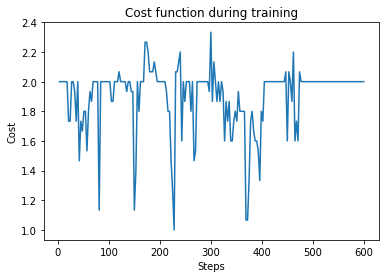

In [11]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [12]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [13]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Valor expectávlel 0.337890625, Label 1 
Valor expectávlel 0.40625, Label 1 
Valor expectávlel 0.37890625, Label 1 
Valor expectávlel 0.419921875, Label 1 
Valor expectávlel 0.408203125, Label 1 
Valor expectávlel 0.380859375, Label 1 
Valor expectávlel 0.302734375, Label 1 
Valor expectávlel 0.4140625, Label 1 
Valor expectávlel 0.400390625, Label 1 
Valor expectávlel 0.412109375, Label 1 
Valor expectávlel 0.37109375, Label 1 
Valor expectávlel 0.458984375, Label 1 
Valor expectávlel 0.34375, Label 1 
Valor expectávlel 0.42578125, Label 1 
Valor expectávlel 0.35546875, Label 1 
Valor expectávlel 0.45703125, Label 1 
Valor expectávlel 0.43359375, Label 1 
Valor expectávlel 0.375, Label 1 
[ 1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Test set accuracy - 0.5


## Cross Entropy Loss

### Parity method

In [14]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [15]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [16]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [ ]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

[array([0.45507812, 0.54492188]), array([0.55859375, 0.44140625]), array([0.40527344, 0.59472656]), array([0.4765625, 0.5234375]), array([0.46484375, 0.53515625]), array([0.44140625, 0.55859375]), array([0.44921875, 0.55078125]), array([0.46484375, 0.53515625]), array([0.44042969, 0.55957031]), array([0.42285156, 0.57714844]), array([0.4609375, 0.5390625]), array([0.4296875, 0.5703125]), array([0.46875, 0.53125]), array([0.453125, 0.546875]), array([0.45996094, 0.54003906]), array([0.44042969, 0.55957031]), array([0.71289062, 0.28710938]), array([0.45898438, 0.54101562]), array([0.57910156, 0.42089844]), array([0.44042969, 0.55957031]), array([0.48339844, 0.51660156]), array([0.546875, 0.453125]), array([0.44238281, 0.55761719]), array([0.5546875, 0.4453125]), array([0.56054688, 0.43945312]), array([0.52539062, 0.47460938]), array([0.39941406, 0.60058594]), array([0.50390625, 0.49609375]), array([0.47949219, 0.52050781]), array([0.4609375, 0.5390625]), array([0.51953125, 0.48046875]), 

[array([0.46777344, 0.53222656]), array([0.515625, 0.484375]), array([0.53710938, 0.46289062]), array([0.52246094, 0.47753906]), array([0.45214844, 0.54785156]), array([0.48925781, 0.51074219]), array([0.45117188, 0.54882812]), array([0.51953125, 0.48046875]), array([0.47265625, 0.52734375]), array([0.49707031, 0.50292969]), array([0.44140625, 0.55859375]), array([0.48339844, 0.51660156]), array([0.45507812, 0.54492188]), array([0.46484375, 0.53515625]), array([0.44140625, 0.55859375]), array([0.48925781, 0.51074219]), array([0.66503906, 0.33496094]), array([0.49804688, 0.50195312]), array([0.5, 0.5]), array([0.484375, 0.515625]), array([0.48046875, 0.51953125]), array([0.55957031, 0.44042969]), array([0.46289062, 0.53710938]), array([0.42773438, 0.57226562]), array([0.47753906, 0.52246094]), array([0.5703125, 0.4296875]), array([0.50390625, 0.49609375]), array([0.44921875, 0.55078125]), array([0.53222656, 0.46777344]), array([0.47558594, 0.52441406]), array([0.50683594, 0.49316406]), 

[array([0.3828125, 0.6171875]), array([0.40820312, 0.59179688]), array([0.40527344, 0.59472656]), array([0.41503906, 0.58496094]), array([0.38574219, 0.61425781]), array([0.38183594, 0.61816406]), array([0.35546875, 0.64453125]), array([0.42480469, 0.57519531]), array([0.3984375, 0.6015625]), array([0.36816406, 0.63183594]), array([0.38964844, 0.61035156]), array([0.40722656, 0.59277344]), array([0.38476562, 0.61523438]), array([0.38769531, 0.61230469]), array([0.34082031, 0.65917969]), array([0.41992188, 0.58007812]), array([0.57519531, 0.42480469]), array([0.38183594, 0.61816406]), array([0.44238281, 0.55761719]), array([0.37109375, 0.62890625]), array([0.37304688, 0.62695312]), array([0.46582031, 0.53417969]), array([0.36621094, 0.63378906]), array([0.36132812, 0.63867188]), array([0.37304688, 0.62695312]), array([0.40136719, 0.59863281]), array([0.40136719, 0.59863281]), array([0.3828125, 0.6171875]), array([0.45898438, 0.54101562]), array([0.37988281, 0.62011719]), array([0.369140

[array([0.58105469, 0.41894531]), array([0.5234375, 0.4765625]), array([0.56933594, 0.43066406]), array([0.51953125, 0.48046875]), array([0.54003906, 0.45996094]), array([0.55761719, 0.44238281]), array([0.49804688, 0.50195312]), array([0.52734375, 0.47265625]), array([0.52539062, 0.47460938]), array([0.54199219, 0.45800781]), array([0.54980469, 0.45019531]), array([0.546875, 0.453125]), array([0.51269531, 0.48730469]), array([0.55175781, 0.44824219]), array([0.546875, 0.453125]), array([0.55859375, 0.44140625]), array([0.45214844, 0.54785156]), array([0.56347656, 0.43652344]), array([0.49023438, 0.50976562]), array([0.54785156, 0.45214844]), array([0.52832031, 0.47167969]), array([0.51660156, 0.48339844]), array([0.53808594, 0.46191406]), array([0.49023438, 0.50976562]), array([0.53417969, 0.46582031]), array([0.53808594, 0.46191406]), array([0.55566406, 0.44433594]), array([0.515625, 0.484375]), array([0.50585938, 0.49414062]), array([0.53710938, 0.46289062]), array([0.49414062, 0.50

[array([0.4921875, 0.5078125]), array([0.42285156, 0.57714844]), array([0.51953125, 0.48046875]), array([0.48242188, 0.51757812]), array([0.48339844, 0.51660156]), array([0.48535156, 0.51464844]), array([0.43847656, 0.56152344]), array([0.47460938, 0.52539062]), array([0.44726562, 0.55273438]), array([0.53417969, 0.46582031]), array([0.4765625, 0.5234375]), array([0.48144531, 0.51855469]), array([0.38574219, 0.61425781]), array([0.42578125, 0.57421875]), array([0.44042969, 0.55957031]), array([0.44140625, 0.55859375]), array([0.4375, 0.5625]), array([0.49316406, 0.50683594]), array([0.4140625, 0.5859375]), array([0.48730469, 0.51269531]), array([0.39746094, 0.60253906]), array([0.38867188, 0.61132812]), array([0.50878906, 0.49121094]), array([0.36621094, 0.63378906]), array([0.34082031, 0.65917969]), array([0.44726562, 0.55273438]), array([0.515625, 0.484375]), array([0.41992188, 0.58007812]), array([0.49511719, 0.50488281]), array([0.45703125, 0.54296875]), array([0.38085938, 0.619140

[array([0.46582031, 0.53417969]), array([0.43066406, 0.56933594]), array([0.44726562, 0.55273438]), array([0.46289062, 0.53710938]), array([0.43945312, 0.56054688]), array([0.43945312, 0.56054688]), array([0.42480469, 0.57519531]), array([0.46777344, 0.53222656]), array([0.4296875, 0.5703125]), array([0.45507812, 0.54492188]), array([0.46582031, 0.53417969]), array([0.46191406, 0.53808594]), array([0.42089844, 0.57910156]), array([0.421875, 0.578125]), array([0.43945312, 0.56054688]), array([0.43359375, 0.56640625]), array([0.40722656, 0.59277344]), array([0.45019531, 0.54980469]), array([0.43652344, 0.56347656]), array([0.4609375, 0.5390625]), array([0.40625, 0.59375]), array([0.41992188, 0.58007812]), array([0.45898438, 0.54101562]), array([0.38671875, 0.61328125]), array([0.40429688, 0.59570312]), array([0.44433594, 0.55566406]), array([0.484375, 0.515625]), array([0.44042969, 0.55957031]), array([0.43652344, 0.56347656]), array([0.47460938, 0.52539062]), array([0.43164062, 0.568359

[array([0.56152344, 0.43847656]), array([0.57128906, 0.42871094]), array([0.61328125, 0.38671875]), array([0.58691406, 0.41308594]), array([0.56445312, 0.43554688]), array([0.52148438, 0.47851562]), array([0.55859375, 0.44140625]), array([0.59863281, 0.40136719]), array([0.57324219, 0.42675781]), array([0.55371094, 0.44628906]), array([0.56152344, 0.43847656]), array([0.59667969, 0.40332031]), array([0.51171875, 0.48828125]), array([0.53515625, 0.46484375]), array([0.54199219, 0.45800781]), array([0.59082031, 0.40917969]), array([0.52929688, 0.47070312]), array([0.55664062, 0.44335938]), array([0.55957031, 0.44042969]), array([0.52246094, 0.47753906]), array([0.5546875, 0.4453125]), array([0.57324219, 0.42675781]), array([0.54394531, 0.45605469]), array([0.54003906, 0.45996094]), array([0.52832031, 0.47167969]), array([0.55761719, 0.44238281]), array([0.61035156, 0.38964844]), array([0.56835938, 0.43164062]), array([0.56933594, 0.43066406]), array([0.57421875, 0.42578125]), array([0.58

[array([0.46875, 0.53125]), array([0.46777344, 0.53222656]), array([0.48925781, 0.51074219]), array([0.49121094, 0.50878906]), array([0.43554688, 0.56445312]), array([0.45410156, 0.54589844]), array([0.45996094, 0.54003906]), array([0.47851562, 0.52148438]), array([0.47558594, 0.52441406]), array([0.47070312, 0.52929688]), array([0.48144531, 0.51855469]), array([0.45800781, 0.54199219]), array([0.42382812, 0.57617188]), array([0.46386719, 0.53613281]), array([0.41113281, 0.58886719]), array([0.47753906, 0.52246094]), array([0.546875, 0.453125]), array([0.46582031, 0.53417969]), array([0.4609375, 0.5390625]), array([0.51074219, 0.48925781]), array([0.41699219, 0.58300781]), array([0.515625, 0.484375]), array([0.46777344, 0.53222656]), array([0.37304688, 0.62695312]), array([0.36914062, 0.63085938]), array([0.51660156, 0.48339844]), array([0.51074219, 0.48925781]), array([0.42480469, 0.57519531]), array([0.50683594, 0.49316406]), array([0.46875, 0.53125]), array([0.41113281, 0.58886719])

[array([0.37402344, 0.62597656]), array([0.31445312, 0.68554688]), array([0.42089844, 0.57910156]), array([0.36230469, 0.63769531]), array([0.35644531, 0.64355469]), array([0.3359375, 0.6640625]), array([0.35058594, 0.64941406]), array([0.38769531, 0.61230469]), array([0.36816406, 0.63183594]), array([0.3671875, 0.6328125]), array([0.36523438, 0.63476562]), array([0.35449219, 0.64550781]), array([0.33007812, 0.66992188]), array([0.36035156, 0.63964844]), array([0.34863281, 0.65136719]), array([0.35449219, 0.64550781]), array([0.36914062, 0.63085938]), array([0.375, 0.625]), array([0.328125, 0.671875]), array([0.34863281, 0.65136719]), array([0.32421875, 0.67578125]), array([0.34570312, 0.65429688]), array([0.359375, 0.640625]), array([0.30273438, 0.69726562]), array([0.27929688, 0.72070312]), array([0.33300781, 0.66699219]), array([0.375, 0.625]), array([0.30566406, 0.69433594]), array([0.33203125, 0.66796875]), array([0.37109375, 0.62890625]), array([0.32421875, 0.67578125]), array([0

[array([0.31835938, 0.68164062]), array([0.37792969, 0.62207031]), array([0.35644531, 0.64355469]), array([0.35546875, 0.64453125]), array([0.37597656, 0.62402344]), array([0.32714844, 0.67285156]), array([0.33300781, 0.66699219]), array([0.34277344, 0.65722656]), array([0.35058594, 0.64941406]), array([0.30859375, 0.69140625]), array([0.3515625, 0.6484375]), array([0.32421875, 0.67578125]), array([0.36523438, 0.63476562]), array([0.31542969, 0.68457031]), array([0.33300781, 0.66699219]), array([0.36425781, 0.63574219]), array([0.578125, 0.421875]), array([0.33105469, 0.66894531]), array([0.42773438, 0.57226562]), array([0.31347656, 0.68652344]), array([0.36035156, 0.63964844]), array([0.42675781, 0.57324219]), array([0.34765625, 0.65234375]), array([0.35449219, 0.64550781]), array([0.30957031, 0.69042969]), array([0.34863281, 0.65136719]), array([0.34179688, 0.65820312]), array([0.38378906, 0.61621094]), array([0.35546875, 0.64453125]), array([0.36132812, 0.63867188]), array([0.345703

[array([0.42578125, 0.57421875]), array([0.41894531, 0.58105469]), array([0.44921875, 0.55078125]), array([0.47167969, 0.52832031]), array([0.42285156, 0.57714844]), array([0.44238281, 0.55761719]), array([0.46289062, 0.53710938]), array([0.41601562, 0.58398438]), array([0.45214844, 0.54785156]), array([0.4296875, 0.5703125]), array([0.43457031, 0.56542969]), array([0.44726562, 0.55273438]), array([0.41699219, 0.58300781]), array([0.42578125, 0.57421875]), array([0.39648438, 0.60351562]), array([0.4140625, 0.5859375]), array([0.578125, 0.421875]), array([0.42675781, 0.57324219]), array([0.45019531, 0.54980469]), array([0.4375, 0.5625]), array([0.40136719, 0.59863281]), array([0.47558594, 0.52441406]), array([0.44726562, 0.55273438]), array([0.45410156, 0.54589844]), array([0.44042969, 0.55957031]), array([0.47167969, 0.52832031]), array([0.44628906, 0.55371094]), array([0.42285156, 0.57714844]), array([0.47070312, 0.52929688]), array([0.40429688, 0.59570312]), array([0.44433594, 0.5556

[array([0.51171875, 0.48828125]), array([0.53222656, 0.46777344]), array([0.45507812, 0.54492188]), array([0.48242188, 0.51757812]), array([0.48535156, 0.51464844]), array([0.47070312, 0.52929688]), array([0.46972656, 0.53027344]), array([0.49316406, 0.50683594]), array([0.46972656, 0.53027344]), array([0.45898438, 0.54101562]), array([0.47363281, 0.52636719]), array([0.48730469, 0.51269531]), array([0.5, 0.5]), array([0.46972656, 0.53027344]), array([0.48535156, 0.51464844]), array([0.45214844, 0.54785156]), array([0.46289062, 0.53710938]), array([0.50683594, 0.49316406]), array([0.51464844, 0.48535156]), array([0.47753906, 0.52246094]), array([0.51464844, 0.48535156]), array([0.48535156, 0.51464844]), array([0.43359375, 0.56640625]), array([0.50292969, 0.49707031]), array([0.52734375, 0.47265625]), array([0.48339844, 0.51660156]), array([0.46582031, 0.53417969]), array([0.49023438, 0.50976562]), array([0.4921875, 0.5078125]), array([0.48242188, 0.51757812]), array([0.49609375, 0.5039

[array([0.43359375, 0.56640625]), array([0.42675781, 0.57324219]), array([0.41699219, 0.58300781]), array([0.42773438, 0.57226562]), array([0.44824219, 0.55175781]), array([0.42773438, 0.57226562]), array([0.41699219, 0.58300781]), array([0.44238281, 0.55761719]), array([0.43652344, 0.56347656]), array([0.44921875, 0.55078125]), array([0.45019531, 0.54980469]), array([0.40527344, 0.59472656]), array([0.41503906, 0.58496094]), array([0.42773438, 0.57226562]), array([0.44824219, 0.55175781]), array([0.42285156, 0.57714844]), array([0.47167969, 0.52832031]), array([0.41503906, 0.58496094]), array([0.41699219, 0.58300781]), array([0.4453125, 0.5546875]), array([0.41699219, 0.58300781]), array([0.421875, 0.578125]), array([0.38378906, 0.61621094]), array([0.43066406, 0.56933594]), array([0.45410156, 0.54589844]), array([0.37988281, 0.62011719]), array([0.44238281, 0.55761719]), array([0.4453125, 0.5546875]), array([0.41601562, 0.58398438]), array([0.42675781, 0.57324219]), array([0.4296875,

[array([0.35058594, 0.64941406]), array([0.31152344, 0.68847656]), array([0.36132812, 0.63867188]), array([0.34960938, 0.65039062]), array([0.36035156, 0.63964844]), array([0.36425781, 0.63574219]), array([0.35351562, 0.64648438]), array([0.33203125, 0.66796875]), array([0.32910156, 0.67089844]), array([0.35839844, 0.64160156]), array([0.31054688, 0.68945312]), array([0.29980469, 0.70019531]), array([0.31738281, 0.68261719]), array([0.3828125, 0.6171875]), array([0.3671875, 0.6328125]), array([0.33886719, 0.66113281]), array([0.29492188, 0.70507812]), array([0.375, 0.625]), array([0.27929688, 0.72070312]), array([0.37109375, 0.62890625]), array([0.31542969, 0.68457031]), array([0.25683594, 0.74316406]), array([0.32910156, 0.67089844]), array([0.33105469, 0.66894531]), array([0.34960938, 0.65039062]), array([0.25683594, 0.74316406]), array([0.37988281, 0.62011719]), array([0.28710938, 0.71289062]), array([0.29296875, 0.70703125]), array([0.296875, 0.703125]), array([0.29101562, 0.708984

[array([0.52539062, 0.47460938]), array([0.45800781, 0.54199219]), array([0.50488281, 0.49511719]), array([0.47851562, 0.52148438]), array([0.49316406, 0.50683594]), array([0.57226562, 0.42773438]), array([0.54589844, 0.45410156]), array([0.51855469, 0.48144531]), array([0.5, 0.5]), array([0.5625, 0.4375]), array([0.49511719, 0.50488281]), array([0.51660156, 0.48339844]), array([0.49023438, 0.50976562]), array([0.52246094, 0.47753906]), array([0.49511719, 0.50488281]), array([0.5078125, 0.4921875]), array([0.46289062, 0.53710938]), array([0.52929688, 0.47070312]), array([0.43457031, 0.56542969]), array([0.50585938, 0.49414062]), array([0.52246094, 0.47753906]), array([0.45410156, 0.54589844]), array([0.52246094, 0.47753906]), array([0.47949219, 0.52050781]), array([0.47949219, 0.52050781]), array([0.46289062, 0.53710938]), array([0.51660156, 0.48339844]), array([0.45800781, 0.54199219]), array([0.45507812, 0.54492188]), array([0.52636719, 0.47363281]), array([0.44628906, 0.55371094]), 

[array([0.39648438, 0.60351562]), array([0.49609375, 0.50390625]), array([0.37402344, 0.62597656]), array([0.43359375, 0.56640625]), array([0.40234375, 0.59765625]), array([0.42285156, 0.57714844]), array([0.41601562, 0.58398438]), array([0.40234375, 0.59765625]), array([0.421875, 0.578125]), array([0.4140625, 0.5859375]), array([0.40820312, 0.59179688]), array([0.37109375, 0.62890625]), array([0.44140625, 0.55859375]), array([0.40039062, 0.59960938]), array([0.43359375, 0.56640625]), array([0.41308594, 0.58691406]), array([0.54199219, 0.45800781]), array([0.38769531, 0.61230469]), array([0.47265625, 0.52734375]), array([0.37597656, 0.62402344]), array([0.4453125, 0.5546875]), array([0.46875, 0.53125]), array([0.37890625, 0.62109375]), array([0.48339844, 0.51660156]), array([0.53417969, 0.46582031]), array([0.43847656, 0.56152344]), array([0.41894531, 0.58105469]), array([0.44921875, 0.55078125]), array([0.45214844, 0.54785156]), array([0.41992188, 0.58007812]), array([0.49023438, 0.50

[array([0.68847656, 0.31152344]), array([0.63574219, 0.36425781]), array([0.70605469, 0.29394531]), array([0.71191406, 0.28808594]), array([0.71972656, 0.28027344]), array([0.71582031, 0.28417969]), array([0.68066406, 0.31933594]), array([0.71777344, 0.28222656]), array([0.69042969, 0.30957031]), array([0.72070312, 0.27929688]), array([0.6796875, 0.3203125]), array([0.734375, 0.265625]), array([0.671875, 0.328125]), array([0.69335938, 0.30664062]), array([0.69726562, 0.30273438]), array([0.69238281, 0.30761719]), array([0.51171875, 0.48828125]), array([0.69238281, 0.30761719]), array([0.63378906, 0.36621094]), array([0.7578125, 0.2421875]), array([0.65625, 0.34375]), array([0.63769531, 0.36230469]), array([0.76953125, 0.23046875]), array([0.54394531, 0.45605469]), array([0.53808594, 0.46191406]), array([0.71191406, 0.28808594]), array([0.72167969, 0.27832031]), array([0.64160156, 0.35839844]), array([0.70019531, 0.29980469]), array([0.68261719, 0.31738281]), array([0.65039062, 0.349609

[array([0.69042969, 0.30957031]), array([0.62890625, 0.37109375]), array([0.67578125, 0.32421875]), array([0.66601562, 0.33398438]), array([0.67773438, 0.32226562]), array([0.64746094, 0.35253906]), array([0.65332031, 0.34667969]), array([0.66992188, 0.33007812]), array([0.68652344, 0.31347656]), array([0.703125, 0.296875]), array([0.69335938, 0.30664062]), array([0.70117188, 0.29882812]), array([0.62597656, 0.37402344]), array([0.67871094, 0.32128906]), array([0.67382812, 0.32617188]), array([0.68066406, 0.31933594]), array([0.58691406, 0.41308594]), array([0.6875, 0.3125]), array([0.64648438, 0.35351562]), array([0.70117188, 0.29882812]), array([0.65527344, 0.34472656]), array([0.65332031, 0.34667969]), array([0.69726562, 0.30273438]), array([0.625, 0.375]), array([0.60253906, 0.39746094]), array([0.66503906, 0.33496094]), array([0.69433594, 0.30566406]), array([0.66503906, 0.33496094]), array([0.67675781, 0.32324219]), array([0.67480469, 0.32519531]), array([0.60839844, 0.39160156])

[array([0.61914062, 0.38085938]), array([0.51074219, 0.48925781]), array([0.58496094, 0.41503906]), array([0.57128906, 0.42871094]), array([0.56835938, 0.43164062]), array([0.55957031, 0.44042969]), array([0.55859375, 0.44140625]), array([0.58691406, 0.41308594]), array([0.56152344, 0.43847656]), array([0.56152344, 0.43847656]), array([0.53027344, 0.46972656]), array([0.56347656, 0.43652344]), array([0.51953125, 0.48046875]), array([0.59863281, 0.40136719]), array([0.53515625, 0.46484375]), array([0.58984375, 0.41015625]), array([0.41796875, 0.58203125]), array([0.56640625, 0.43359375]), array([0.51660156, 0.48339844]), array([0.546875, 0.453125]), array([0.51269531, 0.48730469]), array([0.48144531, 0.51855469]), array([0.57617188, 0.42382812]), array([0.48144531, 0.51855469]), array([0.47753906, 0.52246094]), array([0.51757812, 0.48242188]), array([0.60058594, 0.39941406]), array([0.50585938, 0.49414062]), array([0.54589844, 0.45410156]), array([0.53417969, 0.46582031]), array([0.5429

[array([0.61816406, 0.38183594]), array([0.58300781, 0.41699219]), array([0.6328125, 0.3671875]), array([0.62207031, 0.37792969]), array([0.63183594, 0.36816406]), array([0.60351562, 0.39648438]), array([0.60253906, 0.39746094]), array([0.61425781, 0.38574219]), array([0.61035156, 0.38964844]), array([0.64257812, 0.35742188]), array([0.60253906, 0.39746094]), array([0.63964844, 0.36035156]), array([0.54492188, 0.45507812]), array([0.6171875, 0.3828125]), array([0.63574219, 0.36425781]), array([0.63574219, 0.36425781]), array([0.49414062, 0.50585938]), array([0.65625, 0.34375]), array([0.57128906, 0.42871094]), array([0.63378906, 0.36621094]), array([0.5703125, 0.4296875]), array([0.55957031, 0.44042969]), array([0.61035156, 0.38964844]), array([0.53515625, 0.46484375]), array([0.49414062, 0.50585938]), array([0.58007812, 0.41992188]), array([0.63964844, 0.36035156]), array([0.55175781, 0.44824219]), array([0.59277344, 0.40722656]), array([0.58886719, 0.41113281]), array([0.53808594, 0.

[array([0.66894531, 0.33105469]), array([0.55664062, 0.44335938]), array([0.68261719, 0.31738281]), array([0.64648438, 0.35351562]), array([0.62011719, 0.37988281]), array([0.64453125, 0.35546875]), array([0.63867188, 0.36132812]), array([0.66308594, 0.33691406]), array([0.63476562, 0.36523438]), array([0.6796875, 0.3203125]), array([0.66308594, 0.33691406]), array([0.68554688, 0.31445312]), array([0.61230469, 0.38769531]), array([0.66308594, 0.33691406]), array([0.64550781, 0.35449219]), array([0.65234375, 0.34765625]), array([0.43554688, 0.56445312]), array([0.67285156, 0.32714844]), array([0.54199219, 0.45800781]), array([0.66992188, 0.33007812]), array([0.640625, 0.359375]), array([0.58105469, 0.41894531]), array([0.67578125, 0.32421875]), array([0.57324219, 0.42675781]), array([0.54882812, 0.45117188]), array([0.59375, 0.40625]), array([0.66113281, 0.33886719]), array([0.60351562, 0.39648438]), array([0.625, 0.375]), array([0.63183594, 0.36816406]), array([0.59375, 0.40625]), arra

[array([0.61523438, 0.38476562]), array([0.56347656, 0.43652344]), array([0.5625, 0.4375]), array([0.58203125, 0.41796875]), array([0.58300781, 0.41699219]), array([0.63867188, 0.36132812]), array([0.63476562, 0.36523438]), array([0.60546875, 0.39453125]), array([0.59667969, 0.40332031]), array([0.62207031, 0.37792969]), array([0.59375, 0.40625]), array([0.61425781, 0.38574219]), array([0.58105469, 0.41894531]), array([0.61914062, 0.38085938]), array([0.63085938, 0.36914062]), array([0.61425781, 0.38574219]), array([0.41601562, 0.58398438]), array([0.61035156, 0.38964844]), array([0.54101562, 0.45898438]), array([0.63183594, 0.36816406]), array([0.59570312, 0.40429688]), array([0.54589844, 0.45410156]), array([0.63671875, 0.36328125]), array([0.55761719, 0.44238281]), array([0.57324219, 0.42675781]), array([0.57324219, 0.42675781]), array([0.5859375, 0.4140625]), array([0.54101562, 0.45898438]), array([0.55664062, 0.44335938]), array([0.58007812, 0.41992188]), array([0.61132812, 0.3886

[array([0.703125, 0.296875]), array([0.56738281, 0.43261719]), array([0.66113281, 0.33886719]), array([0.63867188, 0.36132812]), array([0.6640625, 0.3359375]), array([0.65527344, 0.34472656]), array([0.64160156, 0.35839844]), array([0.68261719, 0.31738281]), array([0.66992188, 0.33007812]), array([0.67773438, 0.32226562]), array([0.64746094, 0.35253906]), array([0.65039062, 0.34960938]), array([0.60839844, 0.39160156]), array([0.67089844, 0.32910156]), array([0.64746094, 0.35253906]), array([0.6328125, 0.3671875]), array([0.42675781, 0.57324219]), array([0.69140625, 0.30859375]), array([0.55859375, 0.44140625]), array([0.68652344, 0.31347656]), array([0.61816406, 0.38183594]), array([0.56738281, 0.43261719]), array([0.68554688, 0.31445312]), array([0.53125, 0.46875]), array([0.51757812, 0.48242188]), array([0.61914062, 0.38085938]), array([0.70117188, 0.29882812]), array([0.59765625, 0.40234375]), array([0.63671875, 0.36328125]), array([0.63085938, 0.36914062]), array([0.58886719, 0.41

[array([0.51269531, 0.48730469]), array([0.42773438, 0.57226562]), array([0.49023438, 0.50976562]), array([0.46777344, 0.53222656]), array([0.51464844, 0.48535156]), array([0.46582031, 0.53417969]), array([0.46875, 0.53125]), array([0.50488281, 0.49511719]), array([0.47070312, 0.52929688]), array([0.51171875, 0.48828125]), array([0.46679688, 0.53320312]), array([0.53710938, 0.46289062]), array([0.47167969, 0.52832031]), array([0.47851562, 0.52148438]), array([0.453125, 0.546875]), array([0.50488281, 0.49511719]), array([0.37695312, 0.62304688]), array([0.49804688, 0.50195312]), array([0.39746094, 0.60253906]), array([0.53125, 0.46875]), array([0.47558594, 0.52441406]), array([0.41015625, 0.58984375]), array([0.515625, 0.484375]), array([0.43066406, 0.56933594]), array([0.48828125, 0.51171875]), array([0.43164062, 0.56835938]), array([0.49707031, 0.50292969]), array([0.43945312, 0.56054688]), array([0.48339844, 0.51660156]), array([0.4453125, 0.5546875]), array([0.43847656, 0.56152344])

[array([0.50976562, 0.49023438]), array([0.44140625, 0.55859375]), array([0.51464844, 0.48535156]), array([0.49414062, 0.50585938]), array([0.5078125, 0.4921875]), array([0.55175781, 0.44824219]), array([0.52050781, 0.47949219]), array([0.515625, 0.484375]), array([0.49804688, 0.50195312]), array([0.54785156, 0.45214844]), array([0.50195312, 0.49804688]), array([0.53710938, 0.46289062]), array([0.484375, 0.515625]), array([0.50390625, 0.49609375]), array([0.51464844, 0.48535156]), array([0.5, 0.5]), array([0.38574219, 0.61425781]), array([0.52050781, 0.47949219]), array([0.41308594, 0.58691406]), array([0.55078125, 0.44921875]), array([0.50195312, 0.49804688]), array([0.41992188, 0.58007812]), array([0.52539062, 0.47460938]), array([0.49414062, 0.50585938]), array([0.48730469, 0.51269531]), array([0.46875, 0.53125]), array([0.48828125, 0.51171875]), array([0.46386719, 0.53613281]), array([0.49316406, 0.50683594]), array([0.5, 0.5]), array([0.46875, 0.53125]), array([0.47460938, 0.52539

[array([0.54785156, 0.45214844]), array([0.44628906, 0.55371094]), array([0.49609375, 0.50390625]), array([0.48144531, 0.51855469]), array([0.49609375, 0.50390625]), array([0.51855469, 0.48144531]), array([0.51074219, 0.48925781]), array([0.5078125, 0.4921875]), array([0.47949219, 0.52050781]), array([0.53417969, 0.46582031]), array([0.48339844, 0.51660156]), array([0.53417969, 0.46582031]), array([0.48925781, 0.51074219]), array([0.47460938, 0.52539062]), array([0.48730469, 0.51269531]), array([0.49511719, 0.50488281]), array([0.31640625, 0.68359375]), array([0.48925781, 0.51074219]), array([0.38378906, 0.61621094]), array([0.55664062, 0.44335938]), array([0.48730469, 0.51269531]), array([0.37207031, 0.62792969]), array([0.51953125, 0.48046875]), array([0.46484375, 0.53515625]), array([0.5078125, 0.4921875]), array([0.44433594, 0.55566406]), array([0.48339844, 0.51660156]), array([0.46386719, 0.53613281]), array([0.44726562, 0.55273438]), array([0.48242188, 0.51757812]), array([0.4423

[array([0.51953125, 0.48046875]), array([0.44921875, 0.55078125]), array([0.51367188, 0.48632812]), array([0.47851562, 0.52148438]), array([0.5078125, 0.4921875]), array([0.53027344, 0.46972656]), array([0.54589844, 0.45410156]), array([0.48730469, 0.51269531]), array([0.5078125, 0.4921875]), array([0.5703125, 0.4296875]), array([0.51367188, 0.48632812]), array([0.51171875, 0.48828125]), array([0.50878906, 0.49121094]), array([0.51367188, 0.48632812]), array([0.51074219, 0.48925781]), array([0.49414062, 0.50585938]), array([0.24414062, 0.75585938]), array([0.53613281, 0.46386719]), array([0.40625, 0.59375]), array([0.55078125, 0.44921875]), array([0.51660156, 0.48339844]), array([0.34667969, 0.65332031]), array([0.51367188, 0.48632812]), array([0.49121094, 0.50878906]), array([0.52929688, 0.47070312]), array([0.45214844, 0.54785156]), array([0.50585938, 0.49414062]), array([0.48242188, 0.51757812]), array([0.45410156, 0.54589844]), array([0.47070312, 0.52929688]), array([0.49121094, 0.

[array([0.55371094, 0.44628906]), array([0.51757812, 0.48242188]), array([0.5078125, 0.4921875]), array([0.51464844, 0.48535156]), array([0.546875, 0.453125]), array([0.55664062, 0.44335938]), array([0.53710938, 0.46289062]), array([0.49121094, 0.50878906]), array([0.49121094, 0.50878906]), array([0.54882812, 0.45117188]), array([0.52636719, 0.47363281]), array([0.54394531, 0.45605469]), array([0.53613281, 0.46386719]), array([0.53125, 0.46875]), array([0.54394531, 0.45605469]), array([0.53027344, 0.46972656]), array([0.38671875, 0.61328125]), array([0.55566406, 0.44433594]), array([0.484375, 0.515625]), array([0.56640625, 0.43359375]), array([0.53417969, 0.46582031]), array([0.45019531, 0.54980469]), array([0.52929688, 0.47070312]), array([0.55273438, 0.44726562]), array([0.56445312, 0.43554688]), array([0.48046875, 0.51953125]), array([0.52734375, 0.47265625]), array([0.50195312, 0.49804688]), array([0.47949219, 0.52050781]), array([0.54003906, 0.45996094]), array([0.54589844, 0.4541

[array([0.55664062, 0.44335938]), array([0.4921875, 0.5078125]), array([0.51464844, 0.48535156]), array([0.51660156, 0.48339844]), array([0.57421875, 0.42578125]), array([0.56640625, 0.43359375]), array([0.57519531, 0.42480469]), array([0.55761719, 0.44238281]), array([0.5234375, 0.4765625]), array([0.55664062, 0.44335938]), array([0.55371094, 0.44628906]), array([0.54882812, 0.45117188]), array([0.51171875, 0.48828125]), array([0.58691406, 0.41308594]), array([0.54296875, 0.45703125]), array([0.54980469, 0.45019531]), array([0.31835938, 0.68164062]), array([0.57324219, 0.42675781]), array([0.4453125, 0.5546875]), array([0.56054688, 0.43945312]), array([0.54492188, 0.45507812]), array([0.4453125, 0.5546875]), array([0.54199219, 0.45800781]), array([0.54980469, 0.45019531]), array([0.56738281, 0.43261719]), array([0.44921875, 0.55078125]), array([0.55175781, 0.44824219]), array([0.49902344, 0.50097656]), array([0.4921875, 0.5078125]), array([0.52148438, 0.47851562]), array([0.51855469, 

[array([0.47753906, 0.52246094]), array([0.4765625, 0.5234375]), array([0.49414062, 0.50585938]), array([0.46679688, 0.53320312]), array([0.49609375, 0.50390625]), array([0.49511719, 0.50488281]), array([0.47851562, 0.52148438]), array([0.47949219, 0.52050781]), array([0.484375, 0.515625]), array([0.52148438, 0.47851562]), array([0.4765625, 0.5234375]), array([0.50292969, 0.49707031]), array([0.46289062, 0.53710938]), array([0.48632812, 0.51367188]), array([0.48730469, 0.51269531]), array([0.47949219, 0.52050781]), array([0.38183594, 0.61816406]), array([0.47460938, 0.52539062]), array([0.41699219, 0.58300781]), array([0.49804688, 0.50195312]), array([0.48144531, 0.51855469]), array([0.41015625, 0.58984375]), array([0.47265625, 0.52734375]), array([0.515625, 0.484375]), array([0.484375, 0.515625]), array([0.48242188, 0.51757812]), array([0.50195312, 0.49804688]), array([0.49609375, 0.50390625]), array([0.44628906, 0.55371094]), array([0.48144531, 0.51855469]), array([0.48144531, 0.5185

[array([0.55078125, 0.44921875]), array([0.48535156, 0.51464844]), array([0.53808594, 0.46191406]), array([0.50976562, 0.49023438]), array([0.50195312, 0.49804688]), array([0.53808594, 0.46191406]), array([0.53027344, 0.46972656]), array([0.51660156, 0.48339844]), array([0.52734375, 0.47265625]), array([0.57910156, 0.42089844]), array([0.52734375, 0.47265625]), array([0.52832031, 0.47167969]), array([0.54882812, 0.45117188]), array([0.51269531, 0.48730469]), array([0.52929688, 0.47070312]), array([0.52148438, 0.47851562]), array([0.32617188, 0.67382812]), array([0.52539062, 0.47460938]), array([0.47167969, 0.52832031]), array([0.53808594, 0.46191406]), array([0.5, 0.5]), array([0.4453125, 0.5546875]), array([0.52832031, 0.47167969]), array([0.54003906, 0.45996094]), array([0.5390625, 0.4609375]), array([0.46972656, 0.53027344]), array([0.49804688, 0.50195312]), array([0.49511719, 0.50488281]), array([0.51757812, 0.48242188]), array([0.51953125, 0.48046875]), array([0.51757812, 0.482421

[array([0.54980469, 0.45019531]), array([0.48144531, 0.51855469]), array([0.546875, 0.453125]), array([0.515625, 0.484375]), array([0.52441406, 0.47558594]), array([0.54980469, 0.45019531]), array([0.53222656, 0.46777344]), array([0.52539062, 0.47460938]), array([0.515625, 0.484375]), array([0.5625, 0.4375]), array([0.51171875, 0.48828125]), array([0.53808594, 0.46191406]), array([0.48242188, 0.51757812]), array([0.5234375, 0.4765625]), array([0.52734375, 0.47265625]), array([0.54785156, 0.45214844]), array([0.27929688, 0.72070312]), array([0.5546875, 0.4453125]), array([0.39648438, 0.60351562]), array([0.5546875, 0.4453125]), array([0.51855469, 0.48144531]), array([0.37207031, 0.62792969]), array([0.55859375, 0.44140625]), array([0.46777344, 0.53222656]), array([0.48339844, 0.51660156]), array([0.453125, 0.546875]), array([0.55664062, 0.44335938]), array([0.49414062, 0.50585938]), array([0.46386719, 0.53613281]), array([0.51464844, 0.48535156]), array([0.42578125, 0.57421875]), array(

[array([0.59082031, 0.40917969]), array([0.4765625, 0.5234375]), array([0.62011719, 0.37988281]), array([0.57714844, 0.42285156]), array([0.56640625, 0.43359375]), array([0.57128906, 0.42871094]), array([0.59179688, 0.40820312]), array([0.59667969, 0.40332031]), array([0.58984375, 0.41015625]), array([0.609375, 0.390625]), array([0.54785156, 0.45214844]), array([0.61035156, 0.38964844]), array([0.53125, 0.46875]), array([0.59960938, 0.40039062]), array([0.54882812, 0.45117188]), array([0.55761719, 0.44238281]), array([0.2578125, 0.7421875]), array([0.609375, 0.390625]), array([0.42578125, 0.57421875]), array([0.63378906, 0.36621094]), array([0.53515625, 0.46484375]), array([0.43066406, 0.56933594]), array([0.60742188, 0.39257812]), array([0.46875, 0.53125]), array([0.46777344, 0.53222656]), array([0.5, 0.5]), array([0.59667969, 0.40332031]), array([0.51074219, 0.48925781]), array([0.53222656, 0.46777344]), array([0.56054688, 0.43945312]), array([0.50585938, 0.49414062]), array([0.56152

[array([0.52636719, 0.47363281]), array([0.48535156, 0.51464844]), array([0.50585938, 0.49414062]), array([0.52539062, 0.47460938]), array([0.52246094, 0.47753906]), array([0.54101562, 0.45898438]), array([0.53027344, 0.46972656]), array([0.52050781, 0.47949219]), array([0.50195312, 0.49804688]), array([0.53222656, 0.46777344]), array([0.50683594, 0.49316406]), array([0.51171875, 0.48828125]), array([0.47558594, 0.52441406]), array([0.50976562, 0.49023438]), array([0.52636719, 0.47363281]), array([0.50292969, 0.49707031]), array([0.40917969, 0.59082031]), array([0.51464844, 0.48535156]), array([0.44433594, 0.55566406]), array([0.5625, 0.4375]), array([0.51074219, 0.48925781]), array([0.43359375, 0.56640625]), array([0.50390625, 0.49609375]), array([0.484375, 0.515625]), array([0.45117188, 0.54882812]), array([0.47558594, 0.52441406]), array([0.5546875, 0.4453125]), array([0.48339844, 0.51660156]), array([0.48339844, 0.51660156]), array([0.49414062, 0.50585938]), array([0.44433594, 0.55

[array([0.58203125, 0.41796875]), array([0.51953125, 0.48046875]), array([0.59863281, 0.40136719]), array([0.57128906, 0.42871094]), array([0.58496094, 0.41503906]), array([0.56835938, 0.43164062]), array([0.56152344, 0.43847656]), array([0.58398438, 0.41601562]), array([0.58984375, 0.41015625]), array([0.63183594, 0.36816406]), array([0.56738281, 0.43261719]), array([0.57617188, 0.42382812]), array([0.5390625, 0.4609375]), array([0.57519531, 0.42480469]), array([0.54394531, 0.45605469]), array([0.58886719, 0.41113281]), array([0.26464844, 0.73535156]), array([0.58691406, 0.41308594]), array([0.42089844, 0.57910156]), array([0.59960938, 0.40039062]), array([0.55566406, 0.44433594]), array([0.42285156, 0.57714844]), array([0.61230469, 0.38769531]), array([0.51269531, 0.48730469]), array([0.48535156, 0.51464844]), array([0.52441406, 0.47558594]), array([0.60351562, 0.39648438]), array([0.53417969, 0.46582031]), array([0.54785156, 0.45214844]), array([0.55175781, 0.44824219]), array([0.5,

[array([0.46191406, 0.53808594]), array([0.3828125, 0.6171875]), array([0.45996094, 0.54003906]), array([0.42871094, 0.57128906]), array([0.45410156, 0.54589844]), array([0.4765625, 0.5234375]), array([0.44921875, 0.55078125]), array([0.4453125, 0.5546875]), array([0.4453125, 0.5546875]), array([0.46289062, 0.53710938]), array([0.44140625, 0.55859375]), array([0.45117188, 0.54882812]), array([0.40917969, 0.59082031]), array([0.45605469, 0.54394531]), array([0.44628906, 0.55371094]), array([0.45996094, 0.54003906]), array([0.20898438, 0.79101562]), array([0.47070312, 0.52929688]), array([0.32519531, 0.67480469]), array([0.50097656, 0.49902344]), array([0.43164062, 0.56835938]), array([0.29003906, 0.70996094]), array([0.45507812, 0.54492188]), array([0.40527344, 0.59472656]), array([0.42480469, 0.57519531]), array([0.33398438, 0.66601562]), array([0.47558594, 0.52441406]), array([0.37304688, 0.62695312]), array([0.38183594, 0.61816406]), array([0.41796875, 0.58203125]), array([0.37890625

[array([0.43359375, 0.56640625]), array([0.39941406, 0.60058594]), array([0.42382812, 0.57617188]), array([0.43164062, 0.56835938]), array([0.4140625, 0.5859375]), array([0.42480469, 0.57519531]), array([0.43066406, 0.56933594]), array([0.41503906, 0.58496094]), array([0.41796875, 0.58203125]), array([0.4296875, 0.5703125]), array([0.40527344, 0.59472656]), array([0.45996094, 0.54003906]), array([0.41699219, 0.58300781]), array([0.45019531, 0.54980469]), array([0.41015625, 0.58984375]), array([0.43945312, 0.56054688]), array([0.37890625, 0.62109375]), array([0.4609375, 0.5390625]), array([0.39257812, 0.60742188]), array([0.42285156, 0.57714844]), array([0.4375, 0.5625]), array([0.34667969, 0.65332031]), array([0.43164062, 0.56835938]), array([0.39648438, 0.60351562]), array([0.40527344, 0.59472656]), array([0.41015625, 0.58984375]), array([0.42578125, 0.57421875]), array([0.40917969, 0.59082031]), array([0.40136719, 0.59863281]), array([0.40039062, 0.59960938]), array([0.39648438, 0.60

[array([0.53808594, 0.46191406]), array([0.4921875, 0.5078125]), array([0.56054688, 0.43945312]), array([0.52636719, 0.47363281]), array([0.54492188, 0.45507812]), array([0.54785156, 0.45214844]), array([0.56738281, 0.43261719]), array([0.54980469, 0.45019531]), array([0.54003906, 0.45996094]), array([0.55859375, 0.44140625]), array([0.53808594, 0.46191406]), array([0.56738281, 0.43261719]), array([0.50292969, 0.49707031]), array([0.546875, 0.453125]), array([0.51171875, 0.48828125]), array([0.55273438, 0.44726562]), array([0.25390625, 0.74609375]), array([0.58789062, 0.41210938]), array([0.37207031, 0.62792969]), array([0.57519531, 0.42480469]), array([0.49121094, 0.50878906]), array([0.39355469, 0.60644531]), array([0.55566406, 0.44433594]), array([0.45800781, 0.54199219]), array([0.46875, 0.53125]), array([0.46484375, 0.53515625]), array([0.57421875, 0.42578125]), array([0.49609375, 0.50390625]), array([0.48730469, 0.51269531]), array([0.53027344, 0.46972656]), array([0.46484375, 0.

[array([0.4375, 0.5625]), array([0.38574219, 0.61425781]), array([0.44824219, 0.55175781]), array([0.42480469, 0.57519531]), array([0.46289062, 0.53710938]), array([0.44726562, 0.55273438]), array([0.43164062, 0.56835938]), array([0.4375, 0.5625]), array([0.45117188, 0.54882812]), array([0.44824219, 0.55175781]), array([0.42480469, 0.57519531]), array([0.4453125, 0.5546875]), array([0.42871094, 0.57128906]), array([0.42675781, 0.57324219]), array([0.45898438, 0.54101562]), array([0.44433594, 0.55566406]), array([0.2109375, 0.7890625]), array([0.41992188, 0.58007812]), array([0.30175781, 0.69824219]), array([0.46484375, 0.53515625]), array([0.39746094, 0.60253906]), array([0.29785156, 0.70214844]), array([0.4296875, 0.5703125]), array([0.38183594, 0.61816406]), array([0.3671875, 0.6328125]), array([0.3828125, 0.6171875]), array([0.47851562, 0.52148438]), array([0.38378906, 0.61621094]), array([0.38769531, 0.61230469]), array([0.40917969, 0.59082031]), array([0.40527344, 0.59472656]), ar

[array([0.55859375, 0.44140625]), array([0.45605469, 0.54394531]), array([0.57519531, 0.42480469]), array([0.57128906, 0.42871094]), array([0.5234375, 0.4765625]), array([0.53320312, 0.46679688]), array([0.49316406, 0.50683594]), array([0.54492188, 0.45507812]), array([0.52832031, 0.47167969]), array([0.58105469, 0.41894531]), array([0.5078125, 0.4921875]), array([0.58203125, 0.41796875]), array([0.46582031, 0.53417969]), array([0.50390625, 0.49609375]), array([0.48925781, 0.51074219]), array([0.55664062, 0.44335938]), array([0.34960938, 0.65039062]), array([0.55273438, 0.44726562]), array([0.41992188, 0.58007812]), array([0.5390625, 0.4609375]), array([0.453125, 0.546875]), array([0.47265625, 0.52734375]), array([0.54785156, 0.45214844]), array([0.38476562, 0.61523438]), array([0.38769531, 0.61230469]), array([0.52246094, 0.47753906]), array([0.61132812, 0.38867188]), array([0.4765625, 0.5234375]), array([0.53417969, 0.46582031]), array([0.49316406, 0.50683594]), array([0.41699219, 0.

[array([0.57421875, 0.42578125]), array([0.46289062, 0.53710938]), array([0.57324219, 0.42675781]), array([0.54492188, 0.45507812]), array([0.5234375, 0.4765625]), array([0.52929688, 0.47070312]), array([0.50488281, 0.49511719]), array([0.55664062, 0.44335938]), array([0.5234375, 0.4765625]), array([0.5390625, 0.4609375]), array([0.52734375, 0.47265625]), array([0.57519531, 0.42480469]), array([0.48339844, 0.51660156]), array([0.51855469, 0.48144531]), array([0.52441406, 0.47558594]), array([0.55175781, 0.44824219]), array([0.20800781, 0.79199219]), array([0.56933594, 0.43066406]), array([0.37109375, 0.62890625]), array([0.56835938, 0.43164062]), array([0.47949219, 0.52050781]), array([0.37207031, 0.62792969]), array([0.53417969, 0.46582031]), array([0.43359375, 0.56640625]), array([0.44824219, 0.55175781]), array([0.47265625, 0.52734375]), array([0.56933594, 0.43066406]), array([0.47558594, 0.52441406]), array([0.4921875, 0.5078125]), array([0.52050781, 0.47949219]), array([0.41210938

[array([0.44726562, 0.55273438]), array([0.37011719, 0.62988281]), array([0.44628906, 0.55371094]), array([0.41210938, 0.58789062]), array([0.40820312, 0.59179688]), array([0.46484375, 0.53515625]), array([0.4375, 0.5625]), array([0.40527344, 0.59472656]), array([0.37597656, 0.62402344]), array([0.453125, 0.546875]), array([0.41601562, 0.58398438]), array([0.42675781, 0.57324219]), array([0.38671875, 0.61328125]), array([0.46289062, 0.53710938]), array([0.43066406, 0.56933594]), array([0.4296875, 0.5703125]), array([0.25585938, 0.74414062]), array([0.42285156, 0.57714844]), array([0.31640625, 0.68359375]), array([0.42089844, 0.57910156]), array([0.41308594, 0.58691406]), array([0.28613281, 0.71386719]), array([0.44824219, 0.55175781]), array([0.41503906, 0.58496094]), array([0.42285156, 0.57714844]), array([0.37304688, 0.62695312]), array([0.41992188, 0.58007812]), array([0.40429688, 0.59570312]), array([0.35742188, 0.64257812]), array([0.40527344, 0.59472656]), array([0.38867188, 0.61

[array([0.54199219, 0.45800781]), array([0.45507812, 0.54492188]), array([0.53808594, 0.46191406]), array([0.50683594, 0.49316406]), array([0.53515625, 0.46484375]), array([0.54199219, 0.45800781]), array([0.55273438, 0.44726562]), array([0.515625, 0.484375]), array([0.51171875, 0.48828125]), array([0.56542969, 0.43457031]), array([0.51757812, 0.48242188]), array([0.546875, 0.453125]), array([0.47753906, 0.52246094]), array([0.56054688, 0.43945312]), array([0.51757812, 0.48242188]), array([0.546875, 0.453125]), array([0.22070312, 0.77929688]), array([0.51953125, 0.48046875]), array([0.37890625, 0.62109375]), array([0.51757812, 0.48242188]), array([0.48632812, 0.51367188]), array([0.36328125, 0.63671875]), array([0.51660156, 0.48339844]), array([0.44726562, 0.55273438]), array([0.45996094, 0.54003906]), array([0.4453125, 0.5546875]), array([0.55371094, 0.44628906]), array([0.43652344, 0.56347656]), array([0.45996094, 0.54003906]), array([0.49804688, 0.50195312]), array([0.44824219, 0.55

[array([0.58984375, 0.41015625]), array([0.43066406, 0.56933594]), array([0.65429688, 0.34570312]), array([0.54589844, 0.45410156]), array([0.56152344, 0.43847656]), array([0.54980469, 0.45019531]), array([0.54101562, 0.45898438]), array([0.5625, 0.4375]), array([0.54394531, 0.45605469]), array([0.58886719, 0.41113281]), array([0.56542969, 0.43457031]), array([0.55273438, 0.44726562]), array([0.453125, 0.546875]), array([0.55957031, 0.44042969]), array([0.55761719, 0.44238281]), array([0.54492188, 0.45507812]), array([0.23632812, 0.76367188]), array([0.56445312, 0.43554688]), array([0.36035156, 0.63964844]), array([0.61425781, 0.38574219]), array([0.49511719, 0.50488281]), array([0.35644531, 0.64355469]), array([0.56445312, 0.43554688]), array([0.390625, 0.609375]), array([0.39648438, 0.60351562]), array([0.45800781, 0.54199219]), array([0.62695312, 0.37304688]), array([0.44433594, 0.55566406]), array([0.50976562, 0.49023438]), array([0.51757812, 0.48242188]), array([0.44433594, 0.5556

[array([0.55371094, 0.44628906]), array([0.42871094, 0.57128906]), array([0.6328125, 0.3671875]), array([0.55859375, 0.44140625]), array([0.56640625, 0.43359375]), array([0.54394531, 0.45605469]), array([0.49707031, 0.50292969]), array([0.55078125, 0.44921875]), array([0.49316406, 0.50683594]), array([0.58984375, 0.41015625]), array([0.5234375, 0.4765625]), array([0.53808594, 0.46191406]), array([0.41308594, 0.58691406]), array([0.53027344, 0.46972656]), array([0.484375, 0.515625]), array([0.56054688, 0.43945312]), array([0.15820312, 0.84179688]), array([0.58105469, 0.41894531]), array([0.32324219, 0.67675781]), array([0.61328125, 0.38671875]), array([0.45214844, 0.54785156]), array([0.328125, 0.671875]), array([0.54003906, 0.45996094]), array([0.32617188, 0.67382812]), array([0.32714844, 0.67285156]), array([0.40429688, 0.59570312]), array([0.63574219, 0.36425781]), array([0.38867188, 0.61132812]), array([0.50097656, 0.49902344]), array([0.49609375, 0.50390625]), array([0.36230469, 0.

[array([0.52148438, 0.47851562]), array([0.39160156, 0.60839844]), array([0.58105469, 0.41894531]), array([0.50195312, 0.49804688]), array([0.47753906, 0.52246094]), array([0.49414062, 0.50585938]), array([0.48730469, 0.51269531]), array([0.51953125, 0.48046875]), array([0.45214844, 0.54785156]), array([0.58300781, 0.41699219]), array([0.49707031, 0.50292969]), array([0.52539062, 0.47460938]), array([0.41992188, 0.58007812]), array([0.51367188, 0.48632812]), array([0.484375, 0.515625]), array([0.52734375, 0.47265625]), array([0.15820312, 0.84179688]), array([0.53710938, 0.46289062]), array([0.29785156, 0.70214844]), array([0.56445312, 0.43554688]), array([0.42285156, 0.57714844]), array([0.29101562, 0.70898438]), array([0.51757812, 0.48242188]), array([0.37792969, 0.62207031]), array([0.37011719, 0.62988281]), array([0.40039062, 0.59960938]), array([0.59472656, 0.40527344]), array([0.38769531, 0.61230469]), array([0.45507812, 0.54492188]), array([0.46289062, 0.53710938]), array([0.3671

[array([0.55078125, 0.44921875]), array([0.36230469, 0.63769531]), array([0.59082031, 0.40917969]), array([0.53027344, 0.46972656]), array([0.51464844, 0.48535156]), array([0.49511719, 0.50488281]), array([0.46875, 0.53125]), array([0.53320312, 0.46679688]), array([0.44628906, 0.55371094]), array([0.57910156, 0.42089844]), array([0.52636719, 0.47363281]), array([0.56738281, 0.43261719]), array([0.43457031, 0.56542969]), array([0.53417969, 0.46582031]), array([0.49511719, 0.50488281]), array([0.53808594, 0.46191406]), array([0.15917969, 0.84082031]), array([0.52636719, 0.47363281]), array([0.3046875, 0.6953125]), array([0.57910156, 0.42089844]), array([0.42285156, 0.57714844]), array([0.29492188, 0.70507812]), array([0.54980469, 0.45019531]), array([0.32617188, 0.67382812]), array([0.31835938, 0.68164062]), array([0.43457031, 0.56542969]), array([0.58691406, 0.41308594]), array([0.36230469, 0.63769531]), array([0.45996094, 0.54003906]), array([0.45800781, 0.54199219]), array([0.36914062

[array([0.45214844, 0.54785156]), array([0.34375, 0.65625]), array([0.484375, 0.515625]), array([0.43164062, 0.56835938]), array([0.4609375, 0.5390625]), array([0.41894531, 0.58105469]), array([0.43847656, 0.56152344]), array([0.44042969, 0.55957031]), array([0.41503906, 0.58496094]), array([0.45605469, 0.54394531]), array([0.4375, 0.5625]), array([0.41796875, 0.58203125]), array([0.38769531, 0.61230469]), array([0.44238281, 0.55761719]), array([0.42675781, 0.57324219]), array([0.43261719, 0.56738281]), array([0.17089844, 0.82910156]), array([0.45703125, 0.54296875]), array([0.25, 0.75]), array([0.48046875, 0.51953125]), array([0.41113281, 0.58886719]), array([0.26953125, 0.73046875]), array([0.43652344, 0.56347656]), array([0.37597656, 0.62402344]), array([0.375, 0.625]), array([0.35546875, 0.64453125]), array([0.48828125, 0.51171875]), array([0.35058594, 0.64941406]), array([0.39648438, 0.60351562]), array([0.40527344, 0.59472656]), array([0.34765625, 0.65234375]), array([0.40136719,

[array([0.52832031, 0.47167969]), array([0.359375, 0.640625]), array([0.57714844, 0.42285156]), array([0.50390625, 0.49609375]), array([0.49902344, 0.50097656]), array([0.50292969, 0.49707031]), array([0.48046875, 0.51953125]), array([0.51464844, 0.48535156]), array([0.44921875, 0.55078125]), array([0.53515625, 0.46484375]), array([0.49511719, 0.50488281]), array([0.51074219, 0.48925781]), array([0.41210938, 0.58789062]), array([0.53417969, 0.46582031]), array([0.50585938, 0.49414062]), array([0.47363281, 0.52636719]), array([0.125, 0.875]), array([0.48828125, 0.51171875]), array([0.2734375, 0.7265625]), array([0.52832031, 0.47167969]), array([0.4296875, 0.5703125]), array([0.25585938, 0.74414062]), array([0.51757812, 0.48242188]), array([0.34375, 0.65625]), array([0.37402344, 0.62597656]), array([0.36816406, 0.63183594]), array([0.58691406, 0.41308594]), array([0.35742188, 0.64257812]), array([0.41699219, 0.58300781]), array([0.43554688, 0.56445312]), array([0.34375, 0.65625]), array(

[array([0.54394531, 0.45605469]), array([0.4296875, 0.5703125]), array([0.58203125, 0.41796875]), array([0.52441406, 0.47558594]), array([0.55273438, 0.44726562]), array([0.54003906, 0.45996094]), array([0.52246094, 0.47753906]), array([0.54296875, 0.45703125]), array([0.48925781, 0.51074219]), array([0.56835938, 0.43164062]), array([0.5234375, 0.4765625]), array([0.56738281, 0.43261719]), array([0.46679688, 0.53320312]), array([0.54980469, 0.45019531]), array([0.51953125, 0.48046875]), array([0.53125, 0.46875]), array([0.109375, 0.890625]), array([0.54296875, 0.45703125]), array([0.29296875, 0.70703125]), array([0.61230469, 0.38769531]), array([0.47851562, 0.52148438]), array([0.29589844, 0.70410156]), array([0.57910156, 0.42089844]), array([0.41796875, 0.58203125]), array([0.40820312, 0.59179688]), array([0.40234375, 0.59765625]), array([0.609375, 0.390625]), array([0.39257812, 0.60742188]), array([0.46386719, 0.53613281]), array([0.47753906, 0.52246094]), array([0.390625, 0.609375])

[array([0.43359375, 0.56640625]), array([0.36328125, 0.63671875]), array([0.46289062, 0.53710938]), array([0.45605469, 0.54394531]), array([0.43457031, 0.56542969]), array([0.46289062, 0.53710938]), array([0.421875, 0.578125]), array([0.45507812, 0.54492188]), array([0.41601562, 0.58398438]), array([0.44921875, 0.55078125]), array([0.390625, 0.609375]), array([0.46484375, 0.53515625]), array([0.4140625, 0.5859375]), array([0.45117188, 0.54882812]), array([0.45117188, 0.54882812]), array([0.43847656, 0.56152344]), array([0.17382812, 0.82617188]), array([0.47753906, 0.52246094]), array([0.28417969, 0.71582031]), array([0.49707031, 0.50292969]), array([0.37890625, 0.62109375]), array([0.25195312, 0.74804688]), array([0.4609375, 0.5390625]), array([0.35351562, 0.64648438]), array([0.35546875, 0.64453125]), array([0.36816406, 0.63183594]), array([0.4765625, 0.5234375]), array([0.359375, 0.640625]), array([0.37695312, 0.62304688]), array([0.38867188, 0.61132812]), array([0.34277344, 0.657226

[array([0.55175781, 0.44824219]), array([0.39160156, 0.60839844]), array([0.54589844, 0.45410156]), array([0.51367188, 0.48632812]), array([0.53710938, 0.46289062]), array([0.54394531, 0.45605469]), array([0.49707031, 0.50292969]), array([0.49316406, 0.50683594]), array([0.47070312, 0.52929688]), array([0.55175781, 0.44824219]), array([0.49023438, 0.50976562]), array([0.52050781, 0.47949219]), array([0.45117188, 0.54882812]), array([0.5546875, 0.4453125]), array([0.50488281, 0.49511719]), array([0.52246094, 0.47753906]), array([0.11523438, 0.88476562]), array([0.53222656, 0.46777344]), array([0.31347656, 0.68652344]), array([0.56347656, 0.43652344]), array([0.46582031, 0.53417969]), array([0.30175781, 0.69824219]), array([0.56347656, 0.43652344]), array([0.37304688, 0.62695312]), array([0.40039062, 0.59960938]), array([0.36132812, 0.63867188]), array([0.58105469, 0.41894531]), array([0.39453125, 0.60546875]), array([0.4453125, 0.5546875]), array([0.4375, 0.5625]), array([0.3828125, 0.6

[array([0.55664062, 0.44335938]), array([0.40625, 0.59375]), array([0.59082031, 0.40917969]), array([0.55078125, 0.44921875]), array([0.5703125, 0.4296875]), array([0.60546875, 0.39453125]), array([0.57324219, 0.42675781]), array([0.57128906, 0.42871094]), array([0.48339844, 0.51660156]), array([0.63574219, 0.36425781]), array([0.53613281, 0.46386719]), array([0.59570312, 0.40429688]), array([0.48339844, 0.51660156]), array([0.54199219, 0.45800781]), array([0.53417969, 0.46582031]), array([0.57714844, 0.42285156]), array([0.1484375, 0.8515625]), array([0.5859375, 0.4140625]), array([0.31347656, 0.68652344]), array([0.6171875, 0.3828125]), array([0.51171875, 0.48828125]), array([0.32714844, 0.67285156]), array([0.57226562, 0.42773438]), array([0.41503906, 0.58496094]), array([0.40429688, 0.59570312]), array([0.42089844, 0.57910156]), array([0.60058594, 0.39941406]), array([0.453125, 0.546875]), array([0.48144531, 0.51855469]), array([0.515625, 0.484375]), array([0.44433594, 0.55566406])

[array([0.51367188, 0.48632812]), array([0.4453125, 0.5546875]), array([0.55371094, 0.44628906]), array([0.51367188, 0.48632812]), array([0.52148438, 0.47851562]), array([0.50585938, 0.49414062]), array([0.46582031, 0.53417969]), array([0.50976562, 0.49023438]), array([0.46289062, 0.53710938]), array([0.52832031, 0.47167969]), array([0.49902344, 0.50097656]), array([0.53417969, 0.46582031]), array([0.42285156, 0.57714844]), array([0.49609375, 0.50390625]), array([0.49707031, 0.50292969]), array([0.515625, 0.484375]), array([0.33300781, 0.66699219]), array([0.50976562, 0.49023438]), array([0.39648438, 0.60351562]), array([0.53710938, 0.46289062]), array([0.45605469, 0.54394531]), array([0.35058594, 0.64941406]), array([0.50292969, 0.49707031]), array([0.39550781, 0.60449219]), array([0.40234375, 0.59765625]), array([0.46386719, 0.53613281]), array([0.53125, 0.46875]), array([0.44238281, 0.55761719]), array([0.44140625, 0.55859375]), array([0.4375, 0.5625]), array([0.39746094, 0.60253906

[array([0.62304688, 0.37695312]), array([0.49902344, 0.50097656]), array([0.63183594, 0.36816406]), array([0.59472656, 0.40527344]), array([0.61523438, 0.38476562]), array([0.59277344, 0.40722656]), array([0.57226562, 0.42773438]), array([0.57910156, 0.42089844]), array([0.57128906, 0.42871094]), array([0.61328125, 0.38671875]), array([0.55273438, 0.44726562]), array([0.59277344, 0.40722656]), array([0.53417969, 0.46582031]), array([0.60839844, 0.39160156]), array([0.56445312, 0.43554688]), array([0.58984375, 0.41015625]), array([0.20605469, 0.79394531]), array([0.60351562, 0.39648438]), array([0.41601562, 0.58398438]), array([0.60644531, 0.39355469]), array([0.53808594, 0.46191406]), array([0.359375, 0.640625]), array([0.62207031, 0.37792969]), array([0.49707031, 0.50292969]), array([0.46484375, 0.53515625]), array([0.50585938, 0.49414062]), array([0.625, 0.375]), array([0.47949219, 0.52050781]), array([0.54101562, 0.45898438]), array([0.50976562, 0.49023438]), array([0.49414062, 0.50

In [ ]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [ ]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [ ]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

In [ ]:
print(len(train_data))